In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno as msno
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ls

 Il volume nell'unit� C non ha etichetta.
 Numero di serie del volume: 44A5-0E5F

 Directory di c:\OC\Proj7\Implementez_un_modele_de_scoring

17/11/2023  19:52    <DIR>          .
17/11/2023  19:52    <DIR>          ..
05/11/2023  19:22                69 .gitattributes
23/09/2023  20:08    <DIR>          .github
05/11/2023  19:06               104 .gitignore
16/03/2023  12:36    <DIR>          .idea
05/03/2023  23:22    <DIR>          .ipynb_checkpoints
30/09/2023  12:00    <DIR>          .pytest_cache
30/09/2023  12:15    <DIR>          __pycache__
12/01/2023  20:01            65,264 base_libs.txt
17/11/2023  16:43    <DIR>          Data&output
10/10/2023  22:28            29,406 environment.yml
06/11/2023  22:37             7,548 main.py
17/11/2023  19:51           958,976 Note_methodologique_Silvia_Franze_ok.doc
05/03/2023  23:24    <DIR>          Other_data
16/11/2023  11:40         3,081,418 Proj7.ipynb
18/11/2023  12:13         1,945,453 Proj7_models_run.ipynb
18/11/2023  15:09  

In [3]:
cd Data&output

c:\OC\Proj7\Implementez_un_modele_de_scoring\Data&output


In [4]:
pwd

'c:\\OC\\Proj7\\Implementez_un_modele_de_scoring\\Data&output'

### Import of Train dataset

In [5]:
train_with_target = pd.read_csv('application_train.csv', nrows= None)
train_with_target

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
train_with_target.loc[71618]

SK_ID_CURR                             183052
TARGET                                      0
NAME_CONTRACT_TYPE            Revolving loans
CODE_GENDER                                 M
FLAG_OWN_CAR                                Y
                                   ...       
AMT_REQ_CREDIT_BUREAU_DAY                 0.0
AMT_REQ_CREDIT_BUREAU_WEEK                0.0
AMT_REQ_CREDIT_BUREAU_MON                 1.0
AMT_REQ_CREDIT_BUREAU_QRT                 0.0
AMT_REQ_CREDIT_BUREAU_YEAR                4.0
Name: 71618, Length: 122, dtype: object

In [6]:
train_with_target.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_with_target.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

### Balance between 0 and 1 clients

In [8]:
train_with_target.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [9]:
good_clients_perc = train_with_target.TARGET.value_counts()[0]/len(train_with_target.TARGET)*100
bad_clients_perc = train_with_target.TARGET.value_counts()[1]/len(train_with_target.TARGET)*100
print (' The % of good client is:',good_clients_perc,'\n','The % of bad client is:', bad_clients_perc)

 The % of good client is: 91.92711805431351 
 The % of bad client is: 8.072881945686495


### Subset of data whitout target, but WITH ID     
dataset that will be used (thanks to a flask endpoint) to select a specific row, row that will be used (once the id column removed) to make the prediction on the pre trained Light GBM model

#### Run the following cells ONLY when exporting the dataset whith the "sk curr id" , and running SHAP here 

In [10]:
train = train_with_target.drop('TARGET', axis=1)   ##   uncomment to run
train

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Subset of data without target and ID    uncomment to execute

Run the following cell for normal notebook execution

In [11]:
# train = train_with_target.iloc[:,2:]    ## uncomment to run
# train

### Analysing null data

In [12]:
train.isnull().sum()  # .sort_values(ascending=False)

SK_ID_CURR                        0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 121, dtype: int64

In [13]:
percent_nullval = pd.DataFrame(train_with_target.isnull().sum()/len(train_with_target))   # columns=['columns','percentage']    # .sort_values(ascending=False)
percent_nullval = percent_nullval.reset_index()
percent_nullval.columns = ['columns','percentage']
percent_nullval

,columns,percentage
0,SK_ID_CURR,0.000000
1,TARGET,0.000000
2,NAME_CONTRACT_TYPE,0.000000
3,CODE_GENDER,0.000000
4,FLAG_OWN_CAR,0.000000
...,...,...
117,AMT_REQ_CREDIT_BUREAU_DAY,0.135016
118,AMT_REQ_CREDIT_BUREAU_WEEK,0.135016
119,AMT_REQ_CREDIT_BUREAU_MON,0.135016
120,AMT_REQ_CREDIT_BUREAU_QRT,0.135016


In [14]:
list_cols =  percent_nullval['columns'].tolist()
list_cols

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

### Import description of columns csv to properly analyse them

In [15]:
column_descr = pd.read_csv('HomeCredit_columns_description.csv', nrows= None, encoding= 'ansi')
column_descr

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [16]:
column_descr_subset = column_descr[(column_descr['Table'] == 'application_{train|test}.csv')]
column_descr_subset

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
117,120,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_DAY,Number of enquiries to Credit Bureau about the...,NaN
118,121,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_WEEK,Number of enquiries to Credit Bureau about the...,NaN
119,122,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_MON,Number of enquiries to Credit Bureau about the...,NaN
120,123,application_{train|test}.csv,AMT_REQ_CREDIT_BUREAU_QRT,Number of enquiries to Credit Bureau about the...,NaN


In [17]:
column_descr_subset.loc[column_descr_subset['Row'].isin(list_cols)]['Description'].tolist()

['ID of loan in our sample',
 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
 'Identification if loan is cash or revolving',
 'Gender of the client',
 'Flag if the client owns a car',
 'Flag if client owns a house or flat',
 'Number of children the client has',
 'Income of the client',
 'Credit amount of the loan',
 'Loan annuity',
 'For consumer loans it is the price of the goods for which the loan is given',
 'Who was accompanying client when he was applying for the loan',
 'Clients income type (businessman, working, maternity leave,…)',
 'Level of highest education the client achieved',
 'Family status of the client',
 'What is the housing situation of the client (renting, living with parents, ...)',
 'Normalized population of region where client lives (higher number means the client lives in more populated region)',
 "Client's age in days a

In [18]:
percent_nullval["description"] = column_descr_subset.loc[column_descr_subset['Row'].isin(list_cols)]['Description'].tolist()
percent_nullval.sort_values(by = 'percentage', ascending=False)

,columns,percentage,description
76,COMMONAREA_MEDI,0.698723,Normalized information about building where th...
48,COMMONAREA_AVG,0.698723,Normalized information about building where th...
62,COMMONAREA_MODE,0.698723,Normalized information about building where th...
70,NONLIVINGAPARTMENTS_MODE,0.694330,Normalized information about building where th...
56,NONLIVINGAPARTMENTS_AVG,0.694330,Normalized information about building where th...
...,...,...,...
15,NAME_HOUSING_TYPE,0.000000,What is the housing situation of the client (r...
14,NAME_FAMILY_STATUS,0.000000,Family status of the client
13,NAME_EDUCATION_TYPE,0.000000,Level of highest education the client achieved
12,NAME_INCOME_TYPE,0.000000,"Clients income type (businessman, working, mat..."


### Own car analysis

In [19]:
# analyse flag own car with own car age
train.loc[train['FLAG_OWN_CAR']== 'Y']['OWN_CAR_AGE'].isnull().sum() #just 5 on 104578 clients who owns a car has this missing value

5

In [20]:
train.loc[train['FLAG_OWN_CAR']== 'N']['OWN_CAR_AGE'].isnull().sum()   # 100% of own car = NO

202924

### Choosing columns to drop

In [21]:
to_drop = ['ENTRANCES_MEDI',
           'ENTRANCES_MODE',
           'ENTRANCES_AVG',
           'APARTMENTS_MODE',
           'APARTMENTS_MEDI',
           'APARTMENTS_AVG',
           'HOUSETYPE_MODE',
           'TOTALAREA_MODE',
           'HOUSETYPE_MODE',
    'NONLIVINGAREA_MODE',
           'CNT_CHILDREN',
           'NONLIVINGAREA_AVG',
           'NONLIVINGAREA_MEDI',
           'LIVINGAREA_MEDI',
           'LIVINGAREA_MODE',
           'LIVINGAREA_AVG',
           'FLOORSMIN_AVG',
           'FLAG_EMP_PHONE',
           'FLOORSMIN_MEDI',
           'FLOORSMIN_MODE',
           'FLOORSMAX_MEDI',
           'HOUR_APPR_PROCESS_START',
           'NAME_TYPE_SUITE',
           'FLOORSMAX_AVG',
           'FLOORSMAX_MODE',
           'FONDKAPREMONT_MODE',
    'DAYS_LAST_PHONE_CHANGE',
    'YEARS_BEGINEXPLUATATION_MEDI',
           'YEARS_BEGINEXPLUATATION_AVG',
           'YEARS_BEGINEXPLUATATION_MEDI',
           'YEARS_BEGINEXPLUATATION_MODE',
           'TOTALAREA_MODE',
           'EMERGENCYSTATE_MODE',
           'COMMONAREA_MODE',
           'FLAG_DOCUMENT_3',
           'FLAG_DOCUMENT_4',
           'FLAG_DOCUMENT_5',
           'FLAG_DOCUMENT_6',
           'FLAG_DOCUMENT_7',
           'FLAG_DOCUMENT_8',
           'FLAG_DOCUMENT_9',
           'FLAG_DOCUMENT_10',
           'FLAG_DOCUMENT_11',
           'FLAG_DOCUMENT_12',
           'FLAG_DOCUMENT_13',
           'FLAG_DOCUMENT_14',
           'FLAG_DOCUMENT_15',
           'FLAG_DOCUMENT_16',
           'FLAG_DOCUMENT_17',
           'FLAG_DOCUMENT_18',
           'FLAG_DOCUMENT_19',
           'FLAG_DOCUMENT_20',
           'FLAG_DOCUMENT_21',
           'COMMONAREA_MEDI',
           'COMMONAREA_AVG',
           'NONLIVINGAPARTMENTS_MEDI',
           'NONLIVINGAPARTMENTS_AVG',
           'NONLIVINGAPARTMENTS_MODE',
           'LIVINGAPARTMENTS_AVG',
           'LIVINGAPARTMENTS_MEDI',
           'LIVINGAPARTMENTS_MODE',
           'YEARS_BUILD_AVG',
           'YEARS_BUILD_MEDI',
           'YEARS_BUILD_MODE',
           'LANDAREA_MEDI',
           'LANDAREA_AVG',
           'BASEMENTAREA_MEDI',
           'BASEMENTAREA_AVG',
           'AMT_GOODS_PRICE',
           'ELEVATORS_AVG',
           'ELEVATORS_MEDI',
           'WALLSMATERIAL_MODE',
           'REGION_RATING_CLIENT_W_CITY',
           'LIVE_REGION_NOT_WORK_REGION',
           'LIVE_CITY_NOT_WORK_CITY',
           'DEF_30_CNT_SOCIAL_CIRCLE',
           'OBS_30_CNT_SOCIAL_CIRCLE',
           'OWN_CAR_AGE'
           ]

In [22]:
train_slim = train.drop(columns=to_drop)
train_slim

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,...,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,Cash loans,M,N,Y,202500.0,406597.5,24700.5,Working,Secondary / secondary special,...,0.0377,2.0,2.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,Cash loans,F,N,N,270000.0,1293502.5,35698.5,State servant,Higher education,...,0.0128,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,Revolving loans,M,Y,Y,67500.0,135000.0,6750.0,Working,Secondary / secondary special,...,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,Cash loans,F,N,Y,135000.0,312682.5,29686.5,Working,Secondary / secondary special,...,NaN,2.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,Cash loans,M,N,Y,121500.0,513000.0,21865.5,Working,Secondary / secondary special,...,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,Cash loans,M,N,N,157500.0,254700.0,27558.0,Working,Secondary / secondary special,...,0.0094,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,Cash loans,F,N,Y,72000.0,269550.0,12001.5,Pensioner,Secondary / secondary special,...,0.0592,0.0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,Cash loans,F,N,Y,153000.0,677664.0,29979.0,Working,Higher education,...,NaN,6.0,0.0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,Cash loans,F,N,Y,171000.0,370107.0,20205.0,Commercial associate,Secondary / secondary special,...,NaN,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

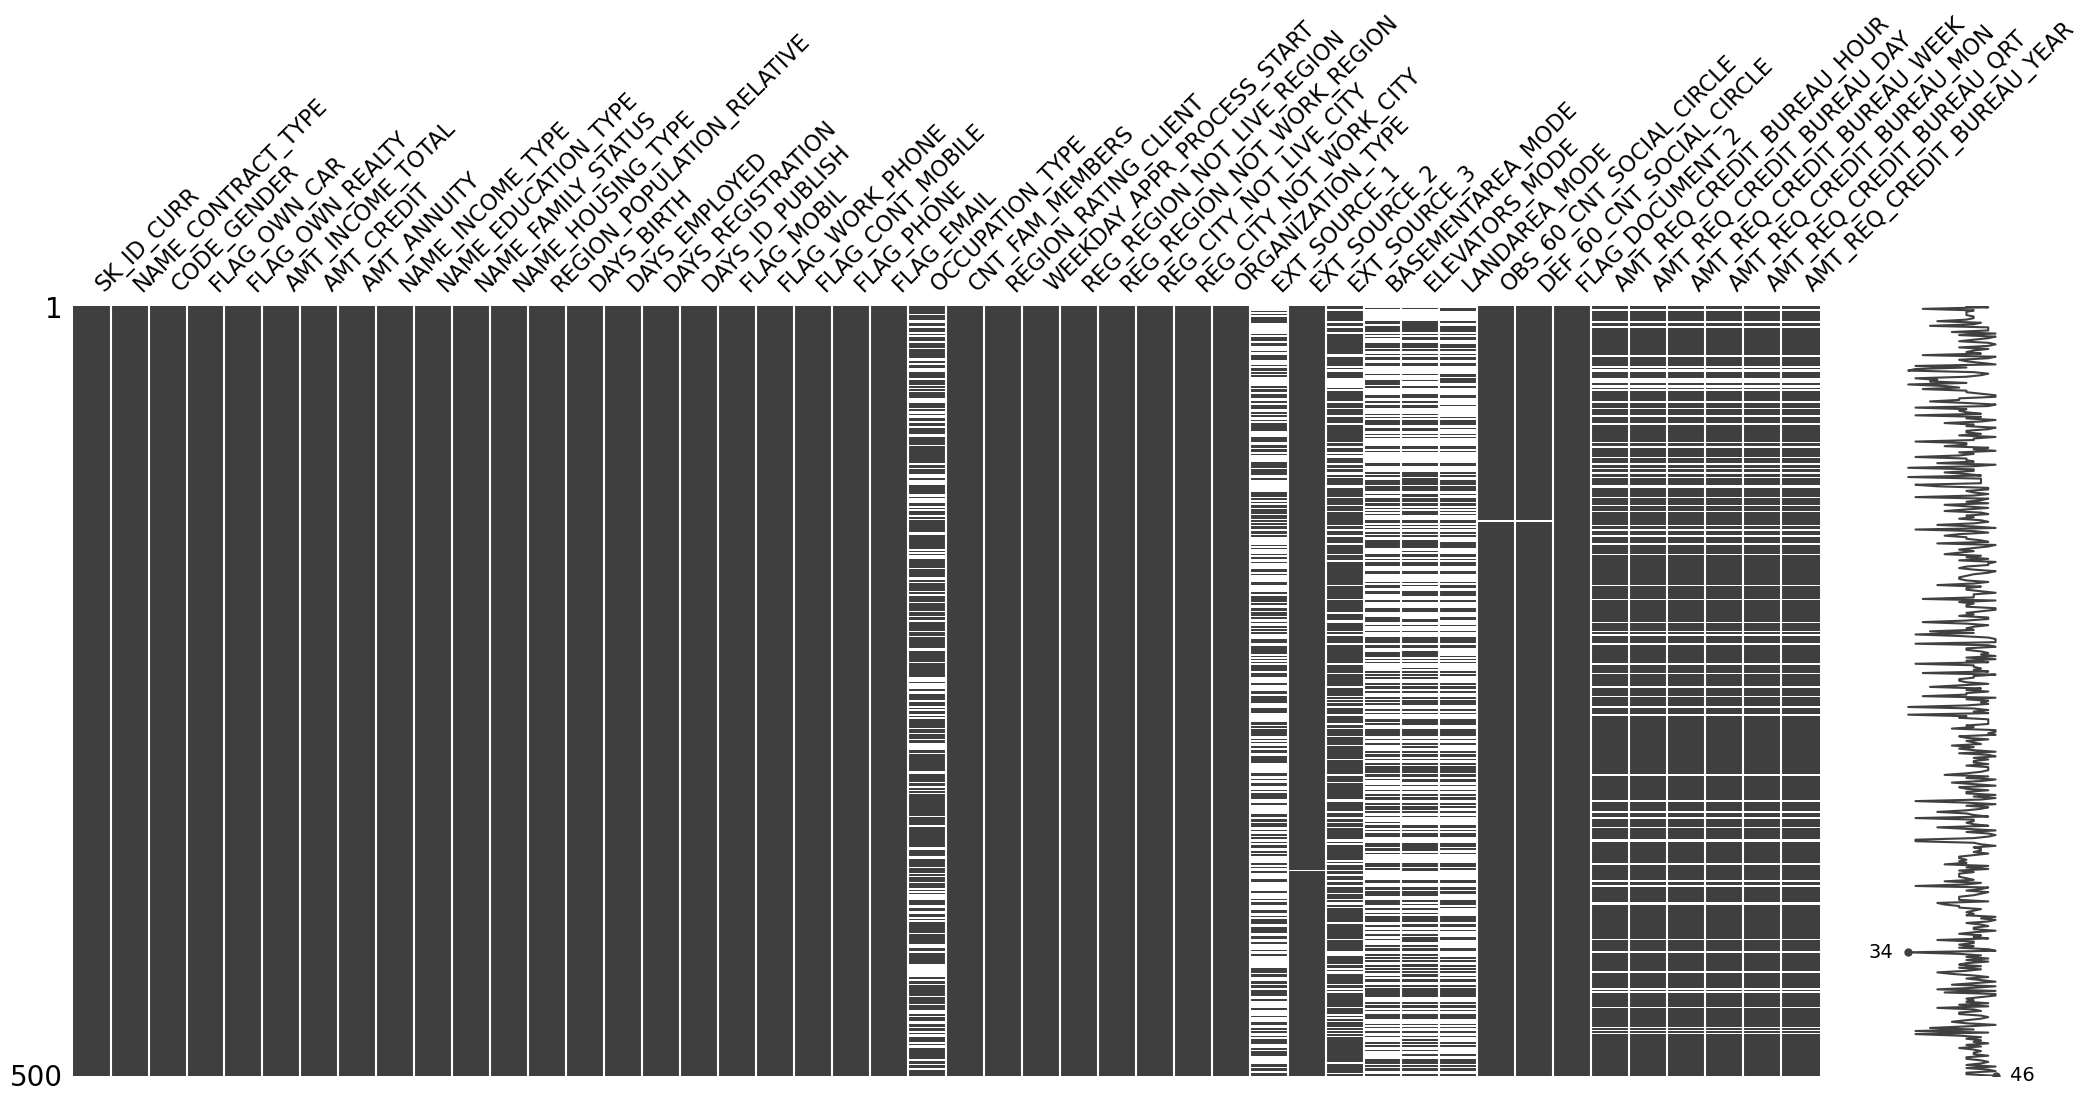

In [23]:
msno.matrix(train_slim.sample(500))

### Correlation between features

In [24]:
corr = train_slim.corr()
corr

,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,...,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.001820,-0.000343,-0.000433,0.000849,-0.001500,0.001366,-0.000973,-0.000384,0.002804,...,0.001548,-0.001423,0.001187,0.000700,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659
AMT_INCOME_TOTAL,-0.001820,1.000000,0.156870,0.191657,0.074796,0.027261,-0.064223,0.027805,0.008506,0.000325,...,-0.003674,-0.013015,-0.013135,-0.001000,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,-0.000343,0.156870,1.000000,0.770138,0.099738,-0.055436,-0.066838,0.009621,-0.006575,0.001436,...,0.002532,0.000239,-0.023767,0.008905,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,-0.000433,0.191657,0.770138,1.000000,0.118429,0.009445,-0.104332,0.038514,0.011268,0.000149,...,0.003621,-0.011731,-0.024001,0.003397,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320
REGION_POPULATION_RELATIVE,0.000849,0.074796,0.099738,0.118429,1.000000,-0.029582,-0.003980,-0.053820,-0.003993,0.001333,...,-0.060558,-0.010638,0.002404,-0.003040,-0.002225,0.001399,-0.002149,0.078607,-0.001279,0.001003
DAYS_BIRTH,-0.001500,0.027261,-0.055436,0.009445,-0.029582,1.000000,-0.615864,0.331912,0.272691,-0.003084,...,0.003800,0.007023,0.001925,-0.001191,0.005285,0.002255,-0.001336,0.001372,-0.011799,-0.071983
DAYS_EMPLOYED,0.001366,-0.064223,-0.066838,-0.104332,-0.003980,-0.615864,1.000000,-0.210242,-0.272378,0.000818,...,-0.008758,0.005888,0.014211,-0.003090,-0.004735,0.000472,0.003072,-0.034457,0.015345,0.049988
DAYS_REGISTRATION,-0.000973,0.027805,0.009621,0.038514,-0.053820,0.331912,-0.210242,1.000000,0.101896,-0.000100,...,0.003354,0.009088,0.004538,-0.004466,-0.002855,-0.000508,-0.001069,-0.011353,-0.001308,-0.024805
DAYS_ID_PUBLISH,-0.000384,0.008506,-0.006575,0.011268,-0.003993,0.272691,-0.272378,0.101896,1.000000,-0.002293,...,-0.008026,-0.012874,0.004328,-0.000349,0.004761,-0.000999,-0.001249,-0.009660,-0.006200,-0.035099
FLAG_MOBIL,0.002804,0.000325,0.001436,0.000149,0.001333,-0.003084,0.000818,-0.000100,-0.002293,1.000000,...,-0.000618,0.001067,0.000499,0.000012,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

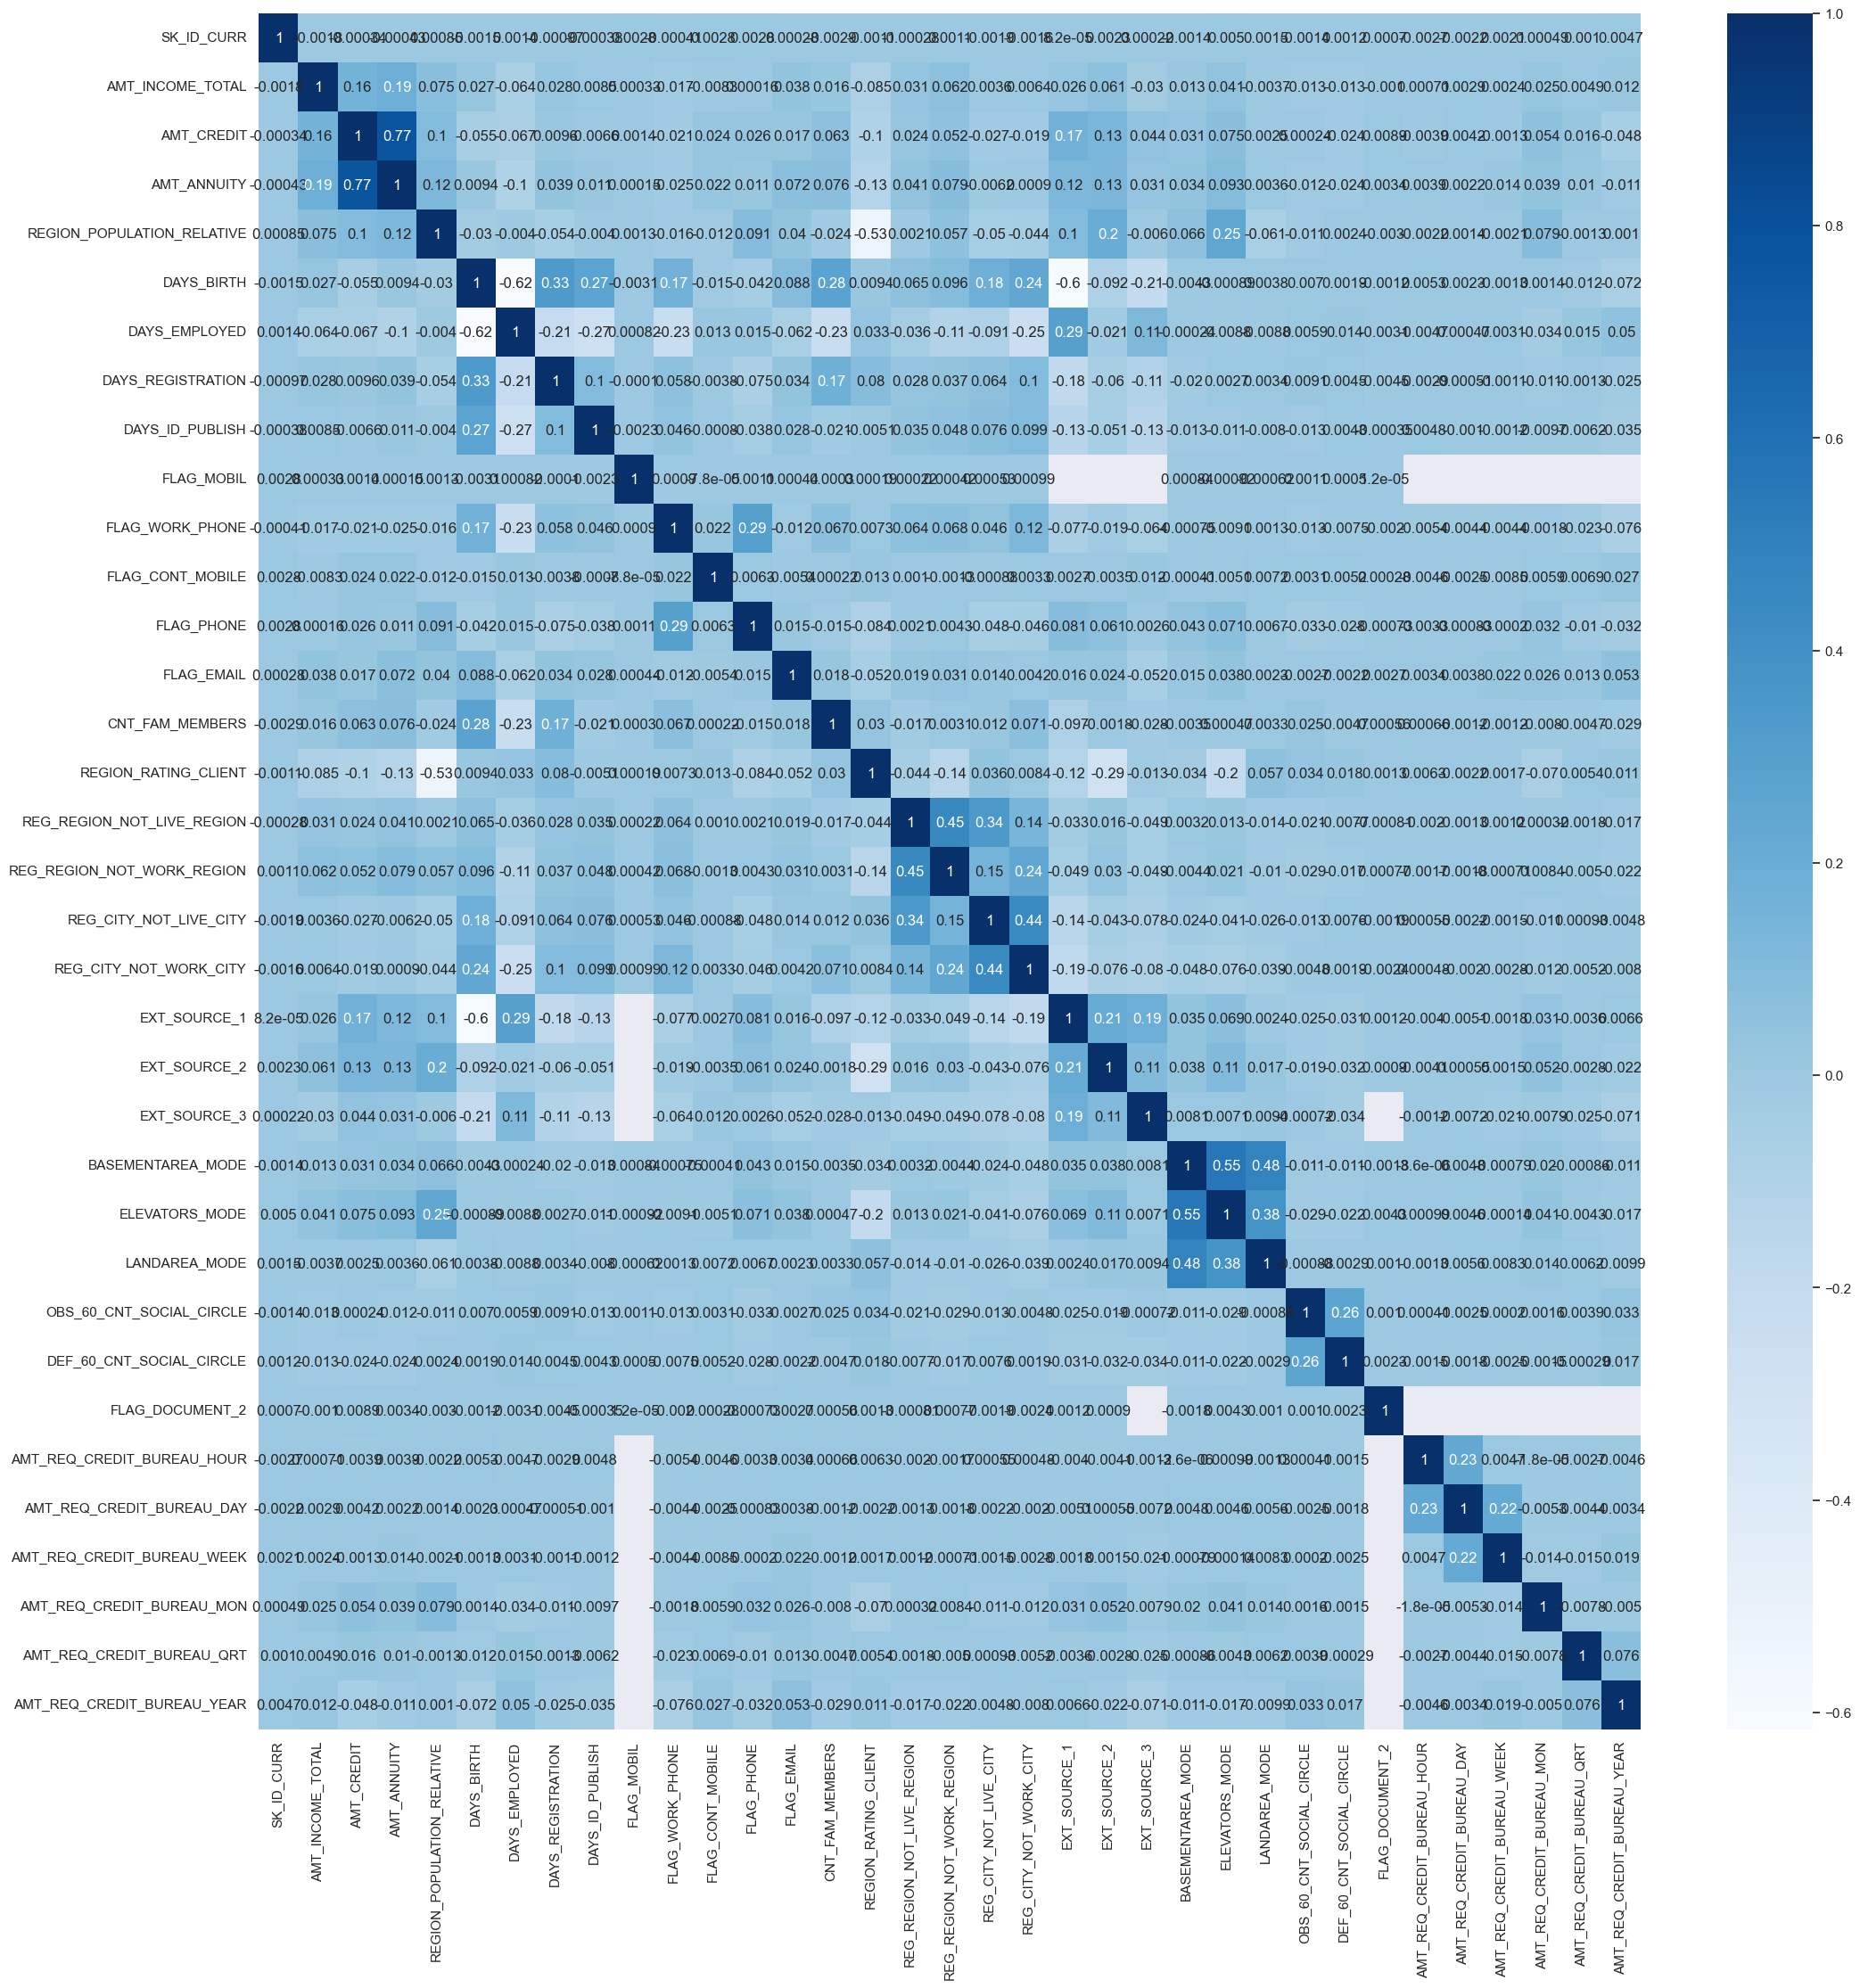

In [25]:
sns.set(rc={'figure.figsize':(25,25)})
sns.heatmap(corr, cmap="Blues", annot=True)

In [26]:
train_slim.isnull().sum()

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
FLAG_MOBIL                         0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
OCCUPATION_TYPE                96391
CNT_FAM_MEMBERS                    2
REGION_RATING_CLIENT               0
WEEKDAY_APPR_PROCESS_START         0
REG_REGION_NOT_LIVE_REGION         0
R

### Substitution of nan with 0 in selected columns

In [27]:
train_slim = train_slim.fillna({'EXT_SOURCE_1':0,
'EXT_SOURCE_2':0,
'EXT_SOURCE_3':0,
'BASEMENTAREA_MODE':0,
'ELEVATORS_MODE':0,
'LANDAREA_MODE':0})

train_slim.isnull().sum()

# 'YEARS_BUILD_MODE':0,
# 'COMMONAREA_MODE':0,
# 'LIVINGAPARTMENTS_MODE':0,
# 'NONLIVINGAPARTMENTS_MODE':0})

SK_ID_CURR                        0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
AMT_INCOME_TOTAL                  0
AMT_CREDIT                        0
AMT_ANNUITY                      12
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
REGION_POPULATION_RELATIVE        0
DAYS_BIRTH                        0
DAYS_EMPLOYED                     0
DAYS_REGISTRATION                 0
DAYS_ID_PUBLISH                   0
FLAG_MOBIL                        0
FLAG_WORK_PHONE                   0
FLAG_CONT_MOBILE                  0
FLAG_PHONE                        0
FLAG_EMAIL                        0
OCCUPATION_TYPE               96391
CNT_FAM_MEMBERS                   2
REGION_RATING_CLIENT              0
WEEKDAY_APPR_PROCESS_START        0
REG_REGION_NOT_LIVE_REGION        0
REG_REGION_NOT_WORK_REGION  

### Substitution of other columns nans with mode

In [28]:
train_slim['CNT_FAM_MEMBERS'] = train_slim['CNT_FAM_MEMBERS'].fillna(train_slim['CNT_FAM_MEMBERS'].mode()[0])
train_slim['OCCUPATION_TYPE'] = train_slim['OCCUPATION_TYPE'].fillna(train_slim['OCCUPATION_TYPE'].mode()[0])
train_slim['OBS_60_CNT_SOCIAL_CIRCLE'] = train_slim['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(train_slim['OBS_60_CNT_SOCIAL_CIRCLE'].mode()[0])
train_slim['DEF_60_CNT_SOCIAL_CIRCLE'] = train_slim['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(train_slim['DEF_60_CNT_SOCIAL_CIRCLE'].mode()[0])
train_slim[['AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']] = train_slim[['AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].fillna(train_slim[['AMT_ANNUITY','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].median())

In [29]:
train_slim.isnull().sum()

SK_ID_CURR                    0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
AMT_INCOME_TOTAL              0
AMT_CREDIT                    0
AMT_ANNUITY                   0
NAME_INCOME_TYPE              0
NAME_EDUCATION_TYPE           0
NAME_FAMILY_STATUS            0
NAME_HOUSING_TYPE             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
DAYS_REGISTRATION             0
DAYS_ID_PUBLISH               0
FLAG_MOBIL                    0
FLAG_WORK_PHONE               0
FLAG_CONT_MOBILE              0
FLAG_PHONE                    0
FLAG_EMAIL                    0
OCCUPATION_TYPE               0
CNT_FAM_MEMBERS               0
REGION_RATING_CLIENT          0
WEEKDAY_APPR_PROCESS_START    0
REG_REGION_NOT_LIVE_REGION    0
REG_REGION_NOT_WORK_REGION    0
REG_CITY_NOT_LIVE_CITY        0
REG_CITY_NOT_WORK_CITY        0
ORGANIZATION_TYPE             0
EXT_SOUR

### Application of kaggle Kernel

In [30]:
# extraction of kernel functions to use as first steps

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv
# edit: modify this function to apply it at train dataset then eventually re use it when I need to split it in train and test , not in the first moment
def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    # train_df = pd.read_csv('application_train.csv', nrows= num_rows)
    df = train_slim   # change name of assigned df based on needs, train_with_target is the untouched one
    
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    # df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

In [31]:
train_feat_eng = application_train()

Train samples: 307511


In [32]:
# applicatin partie modeles, diviser le dataset en train et test et validation 

# recherche des hyperparametres par exemple avec grid search cv, faire la cross validation 

# light gbm a tester, regression logistique, random forest
train_feat_eng.drop(['DAYS_EMPLOYED','DAYS_BIRTH','AMT_INCOME_TOTAL','CNT_FAM_MEMBERS','AMT_ANNUITY','AMT_INCOME_TOTAL','AMT_CREDIT'], inplace=True, axis=1)

In [33]:
train_feat_eng.isnull().sum()   # .describe()

SK_ID_CURR                        0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
REGION_POPULATION_RELATIVE        0
                              ...  
DAYS_EMPLOYED_PERC            55374
INCOME_CREDIT_PERC                0
INCOME_PER_PERSON                 0
ANNUITY_INCOME_PERC               0
PAYMENT_RATE                      0
Length: 147, dtype: int64

In [34]:
# to further explore this choice
# train_feat_eng['DAYS_EMPLOYED'] = train_feat_eng['DAYS_EMPLOYED'].fillna(train_feat_eng['DAYS_EMPLOYED'].mode()[0])
train_feat_eng['DAYS_EMPLOYED_PERC'] = train_feat_eng['DAYS_EMPLOYED_PERC'].fillna(train_feat_eng['DAYS_EMPLOYED_PERC'].median())

In [35]:
train_feat_eng.shape

(307511, 147)

### Separation in X and y set, train-test-split

In [36]:
#! pip install imblearn

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif

In [38]:
X = train_feat_eng # .iloc[:,2:] not necessary now because I've already removed the target at the beginning
y = train_with_target['TARGET']
features_cols = X.columns
X

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0,0,0,0.018801,-3648.0,-2120,1,0,1,...,0,0,0,0,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,1,0,1,0.003541,-1186.0,-291,1,0,1,...,0,0,0,0,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,1,0,0.010032,-4260.0,-2531,1,1,1,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,1,0,0,0.008019,-9833.0,-2437,1,0,1,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,0,0.028663,-4311.0,-3458,1,0,1,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,1,0.032561,-8456.0,-1982,1,0,1,...,0,0,0,0,0,0.025303,0.618375,157500.0,0.174971,0.108198
307507,456252,1,0,0,0.025164,-4388.0,-4090,1,0,1,...,0,0,0,0,1,0.118733,0.267112,72000.0,0.166687,0.044524
307508,456253,1,0,0,0.005002,-6737.0,-5150,1,0,1,...,0,0,0,0,0,0.529266,0.225776,153000.0,0.195941,0.044239
307509,456254,1,0,0,0.005313,-2562.0,-931,1,0,1,...,0,0,0,0,0,0.400134,0.462029,85500.0,0.118158,0.054592


### Select k best features directly from X and Y

In [39]:
# Create and fit selector
selectorr = SelectKBest(f_classif, k=90)
selectorr.fit(X,y)
# Get columns to keep and create new dataframe with those only
cols = selectorr.get_support(indices=True)
X_new = X.iloc[:,cols]
X_new

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0,0,0,0.018801,-3648.0,-2120,0,1,2,0,...,0,0,0,0,0,0,0.067329,202500.0,0.121978,0.060749
1,1,0,1,0.003541,-1186.0,-291,0,1,1,0,...,0,0,0,0,0,0,0.070862,135000.0,0.132217,0.027598
2,0,1,0,0.010032,-4260.0,-2531,1,1,2,0,...,0,0,0,0,0,0,0.011814,67500.0,0.100000,0.050000
3,1,0,0,0.008019,-9833.0,-2437,0,0,2,0,...,0,0,0,0,0,0,0.159905,67500.0,0.219900,0.094941
4,0,0,0,0.028663,-4311.0,-3458,0,0,2,0,...,0,0,0,0,0,0,0.152418,121500.0,0.179963,0.042623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0.032561,-8456.0,-1982,0,0,1,0,...,0,0,0,0,0,0,0.025303,157500.0,0.174971,0.108198
307507,1,0,0,0.025164,-4388.0,-4090,0,1,2,0,...,0,0,0,0,0,1,0.118733,72000.0,0.166687,0.044524
307508,1,0,0,0.005002,-6737.0,-5150,0,0,3,0,...,0,0,0,0,0,0,0.529266,153000.0,0.195941,0.044239
307509,1,0,0,0.005313,-2562.0,-931,0,0,2,0,...,0,0,0,0,0,0,0.400134,85500.0,0.118158,0.054592


In [40]:
# X_new = SelectKBest(mutual_info_classif, k = 80).fit_transform(X,y)
features_colss = X_new.columns
X_new.shape

(307511, 90)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y,
                                                    test_size = 0.3,
                                                    random_state = 6)

In [42]:
X_train.shape, X_test.shape

((215257, 90), (92254, 90))

In [43]:
X_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
201658,1,0,0,0.018029,-6718.0,-326,0,0,3,0,...,0,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148
299253,1,1,0,0.028663,-208.0,-4447,0,1,2,0,...,0,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931
23676,1,0,0,0.024610,-1524.0,-3995,0,0,2,0,...,0,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102
29875,0,1,1,0.025164,-3746.0,-2156,0,0,2,0,...,0,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000
9612,1,0,1,0.031329,-2848.0,-2854,1,1,2,0,...,0,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,0,1,0,0.046220,-1543.0,-4779,0,0,1,0,...,0,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194
157793,1,0,0,0.014520,-6944.0,-1645,0,0,2,0,...,0,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636
148954,1,0,0,0.031329,-2324.0,-991,0,0,2,0,...,0,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477
104381,1,1,1,0.014520,-2803.0,-3633,1,1,2,0,...,0,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240


### Scaling data with StandardScaler

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 0.71977446, -0.71987857,  1.50367051, ..., -0.02935865,
         0.46189274, -1.1622507 ],
       [ 0.71977446, -0.71987857, -0.66503931, ...,  1.17769075,
        -1.24375697, -0.51070176],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.37135598,
        -0.85292657,  0.05408736],
       ...,
       [ 0.71977446,  1.38912316, -0.66503931, ..., -0.1299461 ,
        -0.30286775, -0.23775181],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.43170845,
         1.26064762, -0.10699927],
       [ 0.71977446, -0.71987857,  1.50367051, ..., -0.49206092,
        -1.45026956, -0.6451812 ]])

In [45]:
X_test_scaled

array([[ 0.71977446, -0.71987857, -0.66503931, ..., -0.16347525,
        -0.60612794,  1.70989857],
       [ 0.71977446,  1.38912316, -0.66503931, ..., -0.00924116,
        -0.50997375, -0.74657241],
       [ 0.71977446, -0.71987857, -0.66503931, ...,  0.17181625,
        -0.08536408, -0.24959748],
       ...,
       [ 0.71977446, -0.71987857, -0.66503931, ...,  0.81557593,
        -0.669904  ,  1.14618343],
       [ 0.71977446,  1.38912316,  1.50367051, ..., -0.43170845,
         1.17868337, -1.08875262],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.43170845,
        -1.2968134 , -0.16517623]])

In [46]:
# adding column names on the numpy array
X_test_scld_cols = pd.DataFrame(X_test_scaled, columns=features_colss) # feature_colss contains 90 features, excluding the SK ID CURR, 
                                                                       # that I will add in the next cell
X_test_scld_cols

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


### MODEL SELECTION smote + model inside pipeline to handle imbalanced dataset

### Logistic regression

In [47]:
# remember to add time calculations for each model

In [ ]:
# parameter grid
params1 = {'verbose': [2],
    'classification__penalty' : ['l1', 'l2'],
           'classification__C' : np.logspace(-4, 4, 20),
           'classification__solver' : ['liblinear']}

    #   { 'classification__penalty' : ['l1','l2'],        'classification__C'  : np.logspace(-3,3,7),       'classification__solver'  : ['saga','lbfgs', 'liblinear']  }

In [ ]:
logisticmodel = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.20)),
    ('classification', LogisticRegression())
])

grid1 = GridSearchCV(logisticmodel, param_grid = params1, scoring = 'roc_auc')
grid1.fit(X_train_scaled, y_train)

In [ ]:
logisticmodel.get_params().keys()

In [ ]:
grid1.best_params_

#### Logistic Regression score

In [ ]:
grid1.best_score_

In [ ]:
grid1.best_estimator_.score(X_test_scaled,y_test)

### Lightgbm

In [ ]:
params2 = {'verbose':[2],
    'classification__learning_rate': [0.2,0.3,0.4],
           'classification__max_depth': [1,3,5],
           'classification__n_estimators':[100,300],
           'classification__num_leaves': [20,31],
           'classification__subsample': [0.4,0.8]}

In [ ]:
lightgbmodel = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.25)),    # rajouter ............... SMOTE(sampling_strategy=0.20) sinon trop violent reequilibre
    ('classification', lgb.LGBMClassifier())
])

grid2 = GridSearchCV(lightgbmodel, params2, scoring = 'roc_auc')
grid2.fit(X_train_scaled, y_train)

In [ ]:
lightgbmodel.get_params().keys()


In [ ]:
grid2.best_params_

In [ ]:
# grid2.predict(X_train_scaled)

#### Predict proba light gbm

In [ ]:
grid2.predict_proba(X_test_scaled)

In [ ]:
# voir pouir chaque seuil quei va me rembourser, avoir un colonne par seuil, voir d apres le proa qui va rembourser ou pas , arriver a voir le nombre de faux positif et le nombre de faux negatif, appliquer un coefficient , calculer un  cout pour chaque seuil, et voir quel seuil cout le moin

#### Light GBM Score

In [ ]:
grid2.best_score_

In [ ]:
grid2.best_estimator_.score(X_test_scaled,y_test)

### Random forest

In [ ]:
# Number of trees in random forest
n_estimators = [400]   # int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)
# Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,5]
# Minimum number of samples required to split a node
min_samples_split = [100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [200]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
params3 = {'classification__n_estimators': n_estimators,
           'classification__max_depth': max_depth,
           'classification__min_samples_split': min_samples_split,
           'classification__min_samples_leaf': min_samples_leaf,
           'classification__bootstrap': bootstrap,
           'classification__verbose':[2],
           'classification__n_jobs':[-1],
           'classification__warm_start':[True]}

In [ ]:
randformodel = Pipeline([
    ('sampling', SMOTE(sampling_strategy=0.20)),
    ('classification', RandomForestClassifier())
])

grid3 = GridSearchCV(randformodel, params3, scoring = 'roc_auc',verbose= 3)
grid3.fit(X_train_scaled, y_train)

In [ ]:
randformodel.get_params().keys()

In [ ]:
grid3.best_params_

#### Random Forest score

In [ ]:
grid3.best_score_

In [ ]:
grid3.best_estimator_.score(X_test_scaled,y_test)

#### RF Predict proba

In [ ]:
grid3.predict_proba(X_test)

### MODEL CHOOSED: LIGHT GBM

#### (not necessary) Re running pipeline with LightGBM best grid parameters, and scaler too
not necessary as I need to export 2 objects, the standard scaler and the model needs to be exported separately

In [ ]:
pipe_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('sampling', SMOTE(sampling_strategy=0.20)),
    ('classification', lgb.LGBMClassifier(**grid2.best_params_))
])

In [ ]:
pipe_lgbm.fit(X_train,y_train)

In [ ]:
pipe_lgbm.score(X_test,y_test)

### Running SMOTE and Light GBM  without passing through the pipeline and the gridsearch cv

In [47]:
oversample = SMOTE(sampling_strategy=0.20)

In [48]:
X_train_smote,y_train_smote = oversample.fit_resample(X_train_scaled, y_train)

In [49]:
from collections import Counter
# summarize the new class distribution
counter = Counter(y_train_smote)
print(counter)

Counter({0: 197798, 1: 39559})


In [50]:
# grid2.best_params_

In [51]:
light_best_params = {'learning_rate': 0.2,
                    'max_depth': 3,
                    'n_estimators': 300,
                    'num_leaves': 20,
                    'subsample': 0.4,
                    'verbose': 2}



'''
{'learning_rate': 0.3,
                     'max_depth': 3,
                     'n_estimators': 300,
                     'num_leaves': 20,
                     'subsample': 0.8,
                     'verbose': 2,
                     'metric':'auc'}
'''

"\n{'learning_rate': 0.3,\n                     'max_depth': 3,\n                     'n_estimators': 300,\n                     'num_leaves': 20,\n                     'subsample': 0.8,\n                     'verbose': 2,\n                     'metric':'auc'}\n"

In [52]:
light_for_shap = lgb.LGBMClassifier(**light_best_params)

In [53]:
X_train_smote.shape

(237357, 90)

In [54]:
light_for_shap.fit(X_train_smote, y_train_smote)

[LightGBM] [Info] Number of positive: 39559, number of negative: 197798
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.925826
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.725932
[LightGBM] [Debug] init for col-wise cost 0.105059 seconds, init for row-wise cost 0.140335 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 11410
[LightGBM] [Info] Number of data points in the train set: 237357, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609453
[LightGBM] [Info] Start training from score -1.609453
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 8 and depth = 3
[Ligh

LGBMClassifier(learning_rate=0.2, max_depth=3, n_estimators=300, num_leaves=20,
               subsample=0.4, verbose=2)

In [55]:
y_score = light_for_shap.predict_proba(X_test_scaled)[:, 1]
y_score

array([0.24667399, 0.10740423, 0.07202265, ..., 0.09496717, 0.03971221,
       0.02785981])

Roc auc score 

In [56]:
# see for curiosity the result
from sklearn import metrics

accuracy = metrics.roc_auc_score(y_test, y_score)

print(accuracy)

0.7614837200766533


### Testing the function to filter the dataframe on the sk id curr that returns the prediction 

In [57]:
len(features_colss)

90

In [58]:
### ADD A CELL WHERE I EXECUTE THIS,    input_data_scaled.set_index('SK_ID_CURR', inplace=True)
#### THEN, TEST IF THIS WORKS   selected_customer = input_data_scaled.loc[id_client].drop('SK_ID_CURR', errors='ignore')
### AND RE EXPORT THE NEW LIST IF NECESSARY, TO BE USED IN STREAMLIT APPLICATION

In [59]:
X_test_scld_cols

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


In [62]:
input_data_scaled = X_test_scld_cols.set_index('SK_ID_CURR')
input_data_scaled  # good for client score prediciton

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183


In [63]:
input_data_scaled.loc[111392]  #.drop('SK_ID_CURR', errors='ignore')     #boh 

CODE_GENDER                   0.719774
FLAG_OWN_CAR                  1.389123
FLAG_OWN_REALTY              -0.665039
REGION_POPULATION_RELATIVE    0.712363
DAYS_REGISTRATION             1.167039
                                ...   
ORGANIZATION_TYPE_XNA        -0.468254
DAYS_EMPLOYED_PERC            0.258993
INCOME_PER_PERSON            -0.163475
ANNUITY_INCOME_PERC           0.919571
PAYMENT_RATE                  0.337984
Name: 111392, Length: 90, dtype: float64

In [64]:
id_list = X_test_scld_cols.SK_ID_CURR.tolist()
id_list

[100002,
 100003,
 100004,
 100006,
 100007,
 100008,
 100009,
 100010,
 100011,
 100012,
 100014,
 100015,
 100016,
 100017,
 100018,
 100019,
 100020,
 100021,
 100022,
 100023,
 100024,
 100025,
 100026,
 100027,
 100029,
 100030,
 100031,
 100032,
 100033,
 100034,
 100035,
 100036,
 100037,
 100039,
 100040,
 100041,
 100043,
 100044,
 100045,
 100046,
 100047,
 100048,
 100049,
 100050,
 100051,
 100052,
 100053,
 100054,
 100055,
 100056,
 100058,
 100059,
 100060,
 100061,
 100062,
 100063,
 100064,
 100068,
 100069,
 100070,
 100071,
 100072,
 100073,
 100075,
 100076,
 100077,
 100078,
 100079,
 100080,
 100081,
 100082,
 100083,
 100084,
 100085,
 100086,
 100087,
 100088,
 100089,
 100093,
 100094,
 100095,
 100096,
 100097,
 100098,
 100099,
 100100,
 100101,
 100102,
 100103,
 100104,
 100105,
 100108,
 100110,
 100111,
 100112,
 100113,
 100114,
 100115,
 100116,
 100118,
 100119,
 100120,
 100121,
 100122,
 100123,
 100124,
 100125,
 100126,
 100127,
 100129,
 100130,
 

In [65]:
import random

random.choice(id_list)

120732

In [66]:
esempio_riga = input_data_scaled.loc[random.choice(id_list)].values.reshape(1,-1)   # da non utilizzare
esempio_riga

array([[-1.38915187, -0.71987857,  1.50367051, -1.07577596,  1.11963464,
        -0.68456655, -0.49893709,  1.59765643, -0.10303767, -0.12599975,
        -0.23221964, -0.29255511,  1.82704943,  0.64789488,  0.41646862,
        -1.52472636,  0.15150414, -0.35554311,  0.50157912, -0.61020922,
        -0.27761682, -0.00681603,  0.8875649 , -0.28477676,  1.25865408,
         0.32524103, -0.32524103, -0.55118563, -0.00431078, -0.46815804,
        -0.27490929, -0.00963954,  0.96708825, -0.02198584, -0.56693375,
        -0.11259953,  0.63872998, -0.32874868,  0.75380362, -0.41746682,
        -0.23454362,  0.35695811, -0.09275082, -0.12728729, -0.2255659 ,
        -0.1811323 , -0.12523658, -0.1411524 , -0.31378809,  3.93618158,
        -0.19573927, -0.08220872, -0.27398936, -0.16820968, -0.09353736,
        -0.3420521 , -0.1487697 , -0.06675573, -0.44373741, -0.46204764,
        -0.08919464, -0.09133925,  1.87736175, -0.15000475, -0.18788972,
        -0.05756713, -0.03430339, -0.10417541, -0.0

In [67]:
# Seleziona i dati del cliente specificato dall'ID
import random
esempio_riga = X_test_scld_cols[X_test_scld_cols['SK_ID_CURR'] == random.choice(id_list)].drop('SK_ID_CURR', axis=1) # X_test_scld_cols.loc[X_test_scld_cols['SK_ID_CURR'] == random.choice(id_list)].drop(['SK_ID_CURR'], axis=1)
esempio_riga

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
82459,0.719774,-0.719879,-0.665039,0.753838,-1.227019,1.519131,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.643481,-0.331121,-0.718657,1.161477


In [243]:
esempio_riga['FLAG_PHONE'].values[0]

-0.6259168002968194

In [68]:
[esempio_riga.values.tolist()]

[[[0.7197744565484885,
   -0.7198785748815757,
   -0.6650393097010765,
   0.753837943354371,
   -1.2270194903724012,
   1.5191312589960395,
   -0.49893708967950434,
   -0.6259168002968194,
   -0.10303767091994054,
   -0.12599975152154355,
   -0.23221963901195064,
   -0.29255511171117493,
   -0.5473305656380324,
   -0.7673039883743731,
   0.909674760296284,
   -1.5247263622426201,
   0.25233768581656874,
   -0.3555431107176269,
   0.33891061278037876,
   -0.1756148372310623,
   -0.27761682359353984,
   -0.006816029264537247,
   -0.2680303191805123,
   -0.2847767571346749,
   -0.4412819293200087,
   0.3252410299812804,
   -0.32524102998128035,
   1.8142708209050222,
   -0.0043107753339488636,
   -0.4681580426279237,
   -0.27490929489655763,
   -0.009639544948259585,
   -1.0340317925435976,
   -0.021985835115100886,
   -0.5669337547028748,
   -0.11259952822943767,
   0.6387299756470768,
   3.0418373510284757,
   -1.326605458951813,
   -0.41746681849223977,
   -0.23454361865539436,
   0.35

In [69]:
esempio_riga2 = input_data_scaled.loc[111392] 
esempio_riga2.to_numpy().reshape(1,-1)

array([[ 0.71977446,  1.38912316, -0.66503931,  0.71236255,  1.16703893,
        -0.54202894, -0.49893709, -0.6259168 , -0.10303767, -0.12599975,
        -0.23221964, -0.29255511, -0.54733057,  1.54018991,  0.79550637,
         0.74038476,  0.02330149,  0.05559525, -0.1393348 ,  1.1281683 ,
        -0.27761682, -0.00681603, -0.26803032, -0.28477676,  0.12536341,
         0.32524103, -0.32524103, -0.55118563, -0.00431078, -0.46815804,
        -0.27490929, -0.00963954,  0.96708825, -0.02198584,  1.76387451,
        -0.11259953, -1.56560681, -0.32874868,  0.75380362, -0.41746682,
        -0.23454362,  0.35695811, -0.09275082, -0.12728729, -0.2255659 ,
        -0.1811323 , -0.12523658, -0.1411524 , -0.31378809, -0.25405332,
        -0.19573927, -0.08220872, -0.27398936, -0.16820968, -0.09353736,
        -0.3420521 , -0.1487697 , -0.06675573,  2.25358507, -0.46204764,
        -0.08919464, -0.09133925, -0.53266239, -0.15000475, -0.18788972,
        -0.05756713, -0.03430339, -0.10417541, -0.0

In [70]:
input_data_scaled

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183


In [74]:
# random selecting 100 rows to allow pythonanywhere site to work.  

lighter_input_df = input_data_scaled.sample(n = 100)   
lighter_input_df   

# random selecting 20000 rows to allow streamlit to download the file from github, 66 MB was big site to work.  NO, better use all the lines to have more choice

# lighter_input_df2 = input_data_scaled_fake.sample(n = 20000)   
# lighter_input_df_sorted = lighter_input_df.sort_index()
# lighter_input_df_sorted

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
110102,-1.389152,-0.719879,-0.665039,-0.410074,-1.338860,-0.667329,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,-0.602707,0.476435,0.163966
140433,0.719774,-0.719879,-0.665039,0.842858,0.714569,0.876718,-0.498937,1.597656,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.092318,3.189440,-0.611733,-0.691073
179778,-1.389152,1.389123,-0.665039,0.397106,0.135783,-0.767437,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.567437,-0.163475,-0.476677,0.632943
196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129922,0.719774,-0.719879,-0.665039,0.124915,-1.041944,-0.067346,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.332593,-0.451826,-0.383007,-0.165176
115317,0.719774,1.389123,-0.665039,1.076320,1.413428,0.017514,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.056099,0.674753,-0.053777,-1.215989
187055,0.719774,-0.719879,-0.665039,-0.886680,-1.665864,-1.154609,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,-0.230534,-0.473293,2.347200


In [75]:
lighter_input_df_sorted = lighter_input_df.sort_index()
lighter_input_df_sorted

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937


In [245]:
lista_features = lighter_input_df_sorted.columns.to_list()
lista_features

['SK_ID_CURR',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'BASEMENTAREA_MODE',
 'ELEVATORS_MODE',
 'LANDAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'NAME_CONTRACT_TYPE_Cash loans',
 'NAME_CONTRACT_TYPE_Revolving loans',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NA

In [244]:
index_list = lighter_input_df_sorted.index.to_list()
index_list

[100950,
 103109,
 105548,
 107108,
 107737,
 107776,
 108005,
 108364,
 108778,
 110102,
 110754,
 113081,
 115235,
 115317,
 116288,
 118139,
 118441,
 118467,
 121876,
 121959,
 125014,
 126128,
 127444,
 128035,
 128403,
 128806,
 129396,
 129922,
 131077,
 132081,
 132231,
 133909,
 136892,
 138575,
 138664,
 138743,
 139046,
 139419,
 139716,
 140008,
 140130,
 140433,
 141142,
 142617,
 143193,
 144273,
 144401,
 144407,
 144930,
 145316,
 149072,
 150925,
 151536,
 151991,
 152243,
 153343,
 153992,
 154097,
 154724,
 156148,
 156781,
 157221,
 161245,
 162548,
 163976,
 164763,
 165258,
 165447,
 166022,
 167999,
 169818,
 170566,
 174155,
 174946,
 175051,
 175348,
 176064,
 176887,
 178697,
 179778,
 181021,
 183460,
 184390,
 184666,
 185458,
 185713,
 187055,
 187596,
 188330,
 188526,
 189052,
 191321,
 193308,
 194041,
 194364,
 194458,
 196273,
 200944,
 201302,
 203429]

In [76]:
lighter_input_df_sorted.index.name = None
lighter_input_df_sorted

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937
201302,0.719774,-0.719879,-0.665039,1.829814,-2.453286,-0.914616,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,0.047969,-0.230534,1.914070,1.956059


In [218]:
lighter_input_df_sorted

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
100950,100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937
201302,201302,0.719774,-0.719879,-0.665039,1.829814,-2.453286,-0.914616,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,0.047969,-0.230534,1.914070,1.956059


In [215]:
df_tenrows = lighter_input_df_sorted.sample(n = 10)  
df_tenrows

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
196273,196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
166022,166022,-1.389152,-0.719879,-0.665039,0.842858,0.527223,-0.921245,-0.498937,1.597656,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.065133,-0.230534,-0.543095,1.976144
162548,162548,0.719774,1.389123,-0.665039,1.076320,-0.215917,1.808847,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.660488,0.372991,0.525085,-0.225853
142617,142617,-1.389152,-0.719879,1.503671,-0.982059,1.162781,0.767991,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.727885,-0.230534,-0.586457,-0.208906
140433,140433,0.719774,-0.719879,-0.665039,0.842858,0.714569,0.876718,-0.498937,1.597656,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.092318,3.189440,-0.611733,-0.691073
127444,127444,0.719774,-0.719879,-0.665039,-0.129718,-0.588339,1.382560,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,-0.230534,0.587131,-0.791778
187596,187596,-1.389152,1.389123,-0.665039,3.729300,-1.100987,0.943014,-0.498937,1.597656,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.249896,1.177691,0.746335,0.944247
144273,144273,0.719774,-0.719879,1.503671,-0.087231,1.104306,0.093755,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,-0.381415,-0.908085,-0.504785
118467,118467,0.719774,-0.719879,-0.665039,0.753838,-1.688005,-0.727659,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,-0.129946,-1.057090,-0.409990
108005,108005,0.719774,1.389123,-0.665039,0.753838,-0.501478,-0.868871,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,1.126380,-0.029359,-0.433368,-0.656911


In [119]:
lighter_input_df_sorted.drop('SK_ID_CURR', axis=1, inplace=True)
lighter_input_df_sorted

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937
201302,0.719774,-0.719879,-0.665039,1.829814,-2.453286,-0.914616,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,0.047969,-0.230534,1.914070,1.956059


In [116]:
lighter_input_streamlit = lighter_input_df_sorted 


In [130]:
lighter_input_streamlit

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
100950,100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937
201302,201302,0.719774,-0.719879,-0.665039,1.829814,-2.453286,-0.914616,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,0.047969,-0.230534,1.914070,1.956059


In [129]:
lighter_input_streamlit.insert(0, 'SK_ID_CURR', lighter_input_streamlit.index)


#### Re using longer list, not exporting the small one 

In [188]:
import joblib
#  exportiong lighter version of df to use with PYTHONANYWHERE 
# joblib.dump(lighter_input_df, 'X_tst_light.joblib')
# joblib.dump(lighter_input_py_an, 'input_data_pa_light.joblib')


#                exportiong lighter version of df to use with streamlit 
# joblib.dump(lighter_input_df_sorted, 'input_data_str_light.joblib')

#                re using, and exporting normal version of the df to use with PythonAnywhere etc
# joblib.dump(input_data_scaled, 'X_tst_light.joblib')
 
# import joblib
# joblib.dump(input_data_scaled, 'input_data_scaled_ok.joblib') 

['input_data_str_light.joblib']

#### Due modi equivalenti di calcolare la predizione, ma il secondo è più dispersivo in risorse

[:,0][0] -> probability for class 0, that stands for a negative response, so a good client (credit rembourse)


In [78]:
light_for_shap.predict_proba([lighter_input_df_sorted.loc[196273]])[:,0][0]    #choosed this solution to use in pythonanywhere

0.9532330554388484

In [80]:
light_for_shap.predict_proba(lighter_input_df_sorted.loc[196273].values.reshape(1,-1))[:,0][0]      # [:,0][0] # probability for class 0, that stands for a negative response, so a good client (credit rembourse)

#scritto in maniera piu carina ..... light_for_shap.predict_proba(esempio_riga)[:,0][0]

c:\Anaconda_Silvia\lib\site-packages\lightgbm\basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


0.9532330554388484

In [81]:
# Funzione per fare la predizione all'interno dell API, da usare nella dashboard interattiva


def prediction_client(customer_id, input_data):   # customer_id, poi togliere input data nel file main.py

    ## Load the LightGBM model
    # model = joblib.load("lightgbmodel.joblib")
       
    # Select customer data specified by ID and dropping the ID column
    selected_customer = [input_data.loc[customer_id]]

    # makes the prediction on the index given as input
    predizione = light_for_shap.predict_proba(selected_customer)[:,0][0]
    
    # determines whether the application was accepted or rejected on the basis of the 0.90 threshold
    if predizione > 0.90:
        decision = "accepted"
    else:
        decision = "refused"

    # returns a dictionary with the client ID and the decision made
    return {"Customer id": customer_id, "Decision": decision}

In [92]:
random.choice(lighter_input_df_sorted.index)

203429

In [84]:
import random

id_client = random.choice(lighter_input_df_sorted.index)

print(prediction_client(id_client, lighter_input_df_sorted))

{'Customer id': 110754, 'Decision': 'refused'}


### Exporting lightgbm for Fast API in pickle

In [ ]:
list_col_reduced = X_train.columns.values.tolist()

In [ ]:
for i in list_col_reduced:
    print(i, '= data', [str(i)])

In [ ]:
dict_xtrain = X_train.dtypes.to_dict()
for x,k in dict_xtrain.items():
    dict_xtrain[x]= str(k)
    print("{0}: {1}".format(x.replace(" ", ""), k))

In [ ]:

pd.DataFrame(X_train.dtypes).values

In [ ]:
ls

In [ ]:
import pickle
pickle_out = open("lightgbm.pkl", "wb")
pickle.dump(light_for_shap,pickle_out)
pickle_out.close()

In [ ]:
light_for_shap.predict(X_test)

In [ ]:
light_for_shap.score(X_test_scaled,y_test)

In [164]:
X_test_strl_jnd= X_test.join(train[['SK_ID_CURR']])
X_test_strl_jnd

,PREDICTION,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,SK_ID_CURR
201658,NaN,1,0,0,0.018029,-6718.0,-326,0,0,3,...,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148,333760
299253,NaN,1,1,0,0.028663,-208.0,-4447,0,1,2,...,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931,446681
23676,1.0,1,0,0,0.024610,-1524.0,-3995,0,0,2,...,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102,127549
29875,1.0,0,1,1,0.025164,-3746.0,-2156,0,0,2,...,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000,134681
9612,1.0,1,0,1,0.031329,-2848.0,-2854,1,1,2,...,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915,111178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,NaN,0,1,0,0.046220,-1543.0,-4779,0,0,1,...,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194,377384
157793,NaN,1,0,0,0.014520,-6944.0,-1645,0,0,2,...,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636,282899
148954,NaN,1,0,0,0.031329,-2324.0,-991,0,0,2,...,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477,272698
104381,NaN,1,1,1,0.014520,-2803.0,-3633,1,1,2,...,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240,221138


In [165]:
colonna_id = X_test_strl_jnd['SK_ID_CURR']
X_test_strl_jnd.drop('SK_ID_CURR', axis=1, inplace=True)
X_test_strl_jnd.insert(0, 'SK_ID_CURR', colonna_id)
X_test_strl_jnd

,SK_ID_CURR,PREDICTION,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
201658,333760,NaN,1,0,0,0.018029,-6718.0,-326,0,0,...,0,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148
299253,446681,NaN,1,1,0,0.028663,-208.0,-4447,0,1,...,0,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931
23676,127549,1.0,1,0,0,0.024610,-1524.0,-3995,0,0,...,0,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102
29875,134681,1.0,0,1,1,0.025164,-3746.0,-2156,0,0,...,0,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000
9612,111178,1.0,1,0,1,0.031329,-2848.0,-2854,1,1,...,0,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,377384,NaN,0,1,0,0.046220,-1543.0,-4779,0,0,...,0,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194
157793,282899,NaN,1,0,0,0.014520,-6944.0,-1645,0,0,...,0,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636
148954,272698,NaN,1,0,0,0.031329,-2324.0,-991,0,0,...,0,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477
104381,221138,NaN,1,1,1,0.014520,-2803.0,-3633,1,1,...,0,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240


In [174]:
# X_test_strl_jnd.drop('PREDICTION', axis=1, inplace=True)

In [172]:
df_proba_strlt.index = X_test_strl_jnd.index
df_proba_strlt

,zero,prediction
201658,0.753326,0
299253,0.892596,0
23676,0.927977,1
29875,0.974238,1
9612,0.940438,1
...,...,...
239532,0.986801,1
157793,0.917504,1
148954,0.905033,1
104381,0.960288,1


### starting df for function that calculates mean based on features and good or bad clients

In [191]:
X_test_strl_jnd = X_test_strl_jnd.drop('PREDICTION', axis=1)

In [192]:
X_test_strl_jnd.insert(0,'PREDICTION',df_proba_strlt['prediction'])
X_test_strl_jnd

,PREDICTION,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
201658,1,333760,1,0,0,0.018029,-6718.0,-326,0,0,...,0,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148
299253,1,446681,1,1,0,0.028663,-208.0,-4447,0,1,...,0,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931
23676,0,127549,1,0,0,0.024610,-1524.0,-3995,0,0,...,0,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102
29875,0,134681,0,1,1,0.025164,-3746.0,-2156,0,0,...,0,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000
9612,0,111178,1,0,1,0.031329,-2848.0,-2854,1,1,...,0,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,0,377384,0,1,0,0.046220,-1543.0,-4779,0,0,...,0,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194
157793,0,282899,1,0,0,0.014520,-6944.0,-1645,0,0,...,0,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636
148954,0,272698,1,0,0,0.031329,-2324.0,-991,0,0,...,0,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477
104381,0,221138,1,1,1,0.014520,-2803.0,-3633,1,1,...,0,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240


In [143]:
X_test

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
201658,1,0,0,0.018029,-6718.0,-326,0,0,3,0,...,0,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148
299253,1,1,0,0.028663,-208.0,-4447,0,1,2,0,...,0,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931
23676,1,0,0,0.024610,-1524.0,-3995,0,0,2,0,...,0,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102
29875,0,1,1,0.025164,-3746.0,-2156,0,0,2,0,...,0,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000
9612,1,0,1,0.031329,-2848.0,-2854,1,1,2,0,...,0,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,0,1,0,0.046220,-1543.0,-4779,0,0,1,0,...,0,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194
157793,1,0,0,0.014520,-6944.0,-1645,0,0,2,0,...,0,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636
148954,1,0,0,0.031329,-2324.0,-991,0,0,2,0,...,0,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477
104381,1,1,1,0.014520,-2803.0,-3633,1,1,2,0,...,0,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240


In [149]:
X_test_scaled

array([[ 0.71977446, -0.71987857, -0.66503931, ..., -0.16347525,
        -0.60612794,  1.70989857],
       [ 0.71977446,  1.38912316, -0.66503931, ..., -0.00924116,
        -0.50997375, -0.74657241],
       [ 0.71977446, -0.71987857, -0.66503931, ...,  0.17181625,
        -0.08536408, -0.24959748],
       ...,
       [ 0.71977446, -0.71987857, -0.66503931, ...,  0.81557593,
        -0.669904  ,  1.14618343],
       [ 0.71977446,  1.38912316,  1.50367051, ..., -0.43170845,
         1.17868337, -1.08875262],
       [-1.38915187,  1.38912316, -0.66503931, ..., -0.43170845,
        -1.2968134 , -0.16517623]])

In [150]:
X_test_scld_cols

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,207120,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


In [146]:
light_for_shap.predict_proba(X_test_scaled)

array([[0.75332601, 0.24667399],
       [0.89259577, 0.10740423],
       [0.92797735, 0.07202265],
       ...,
       [0.90503283, 0.09496717],
       [0.96028779, 0.03971221],
       [0.97214019, 0.02785981]])

### Developpement fonction Score metier

In [93]:
df_proba = pd.DataFrame(light_for_shap.predict_proba(X_test_scaled))


In [94]:
# df_proba = pd.DataFrame(grid2.predict_proba(X_test_scaled))


In [95]:
df_proba.columns = ['zero','one']

#### dataframe che servirà per istogramma clienti su streamlit

In [148]:
df_proba_strlt = df_proba[['zero']]
df_proba_strlt

,zero
0,0.753326
1,0.892596
2,0.927977
3,0.974238
4,0.940438
...,...
92249,0.986801
92250,0.917504
92251,0.905033
92252,0.960288


In [186]:
df_proba_strlt['prediction'] = np.where(df_proba_strlt['zero'] > 0.90, 0, 1)
df_proba_strlt


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,zero,prediction
201658,0.753326,1
299253,0.892596,1
23676,0.927977,0
29875,0.974238,0
9612,0.940438,0
...,...,...
239532,0.986801,0
157793,0.917504,0
148954,0.905033,0
104381,0.960288,0


In [202]:
df_proba

,zero,one,truth,cout_0.05,cout_0.1,cout_0.15,cout_0.2,cout_0.25,cout_0.3,cout_0.35,...,cout_0.55,cout_0.6,cout_0.65,cout_0.7,cout_0.75,cout_0.8,cout_0.85,cout_0.9,cout_0.95,cout_1
0,0.753326,0.246674,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
1,0.892596,0.107404,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0.927977,0.072023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0.974238,0.025762,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.940438,0.059562,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,0.986801,0.013199,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
92250,0.917504,0.082496,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
92251,0.905033,0.094967,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
92252,0.960288,0.039712,1,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0


In [96]:
df_proba['truth'] = y_test.values
df_proba

,zero,one,truth
0,0.753326,0.246674,0
1,0.892596,0.107404,0
2,0.927977,0.072023,0
3,0.974238,0.025762,0
4,0.940438,0.059562,0
...,...,...,...
92249,0.986801,0.013199,0
92250,0.917504,0.082496,0
92251,0.905033,0.094967,0
92252,0.960288,0.039712,1


In [97]:
def type_Decision(x,seuil):
    if x['zero'] > seuil and x['truth'] ==0:
        return 0
    if x['zero'] > seuil and x['truth'] ==1:
        return 10
    if x['zero'] <= seuil and x['truth'] ==0:
        return 1
    if x['zero'] <= seuil and x['truth'] ==1:
        return 0

In [98]:
df_proba['cout_0.05']=df_proba.apply(lambda x: type_Decision(x,0.05),axis=1)
df_proba['cout_0.1']=df_proba.apply(lambda x: type_Decision(x,0.1),axis=1)
df_proba['cout_0.15']=df_proba.apply(lambda x: type_Decision(x,0.15),axis=1)
df_proba['cout_0.2']=df_proba.apply(lambda x: type_Decision(x,0.2),axis=1)
df_proba['cout_0.25']=df_proba.apply(lambda x: type_Decision(x,0.25),axis=1)
df_proba['cout_0.3']=df_proba.apply(lambda x: type_Decision(x,0.3),axis=1)
df_proba['cout_0.35']=df_proba.apply(lambda x: type_Decision(x,0.35),axis=1)
df_proba['cout_0.4']=df_proba.apply(lambda x: type_Decision(x,0.4),axis=1)
df_proba['cout_0.45']=df_proba.apply(lambda x: type_Decision(x,0.45),axis=1)
df_proba['cout_0.5']=df_proba.apply(lambda x: type_Decision(x,0.5),axis=1)
df_proba['cout_0.55']=df_proba.apply(lambda x: type_Decision(x,0.55),axis=1)
df_proba['cout_0.6']=df_proba.apply(lambda x: type_Decision(x,0.6),axis=1)
df_proba['cout_0.65']=df_proba.apply(lambda x: type_Decision(x,0.65),axis=1)
df_proba['cout_0.7']=df_proba.apply(lambda x: type_Decision(x,0.7),axis=1)
df_proba['cout_0.75']=df_proba.apply(lambda x: type_Decision(x,0.75),axis=1)
df_proba['cout_0.8']=df_proba.apply(lambda x: type_Decision(x,0.8),axis=1)
df_proba['cout_0.85']=df_proba.apply(lambda x: type_Decision(x,0.85),axis=1)
df_proba['cout_0.9']=df_proba.apply(lambda x: type_Decision(x,0.9),axis=1)
df_proba['cout_0.95']=df_proba.apply(lambda x: type_Decision(x,0.95),axis=1)
df_proba['cout_1']=df_proba.apply(lambda x: type_Decision(x,1),axis=1)

df_proba

,zero,one,truth,cout_0.05,cout_0.1,cout_0.15,cout_0.2,cout_0.25,cout_0.3,cout_0.35,...,cout_0.55,cout_0.6,cout_0.65,cout_0.7,cout_0.75,cout_0.8,cout_0.85,cout_0.9,cout_0.95,cout_1
0,0.753326,0.246674,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1
1,0.892596,0.107404,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
2,0.927977,0.072023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0.974238,0.025762,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.940438,0.059562,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,0.986801,0.013199,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
92250,0.917504,0.082496,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
92251,0.905033,0.094967,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
92252,0.960288,0.039712,1,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0


In [99]:
df_proba.sum() # je peut retrouver le cout pour chaque seuil
#ensuite creer un autre df avec  colonne seuil, colonne couts, ensuite tracer la courbe

zero         84374.491517
one           7879.508483
truth         7366.000000
cout_0.05    73660.000000
cout_0.1     73660.000000
cout_0.15    73650.000000
cout_0.2     73640.000000
cout_0.25    73615.000000
cout_0.3     73519.000000
cout_0.35    73351.000000
cout_0.4     73006.000000
cout_0.45    72507.000000
cout_0.5     71905.000000
cout_0.55    70689.000000
cout_0.6     69188.000000
cout_0.65    67141.000000
cout_0.7     64298.000000
cout_0.75    60658.000000
cout_0.8     56192.000000
cout_0.85    51543.000000
cout_0.9     48421.000000
cout_0.95    54875.000000
cout_1       84888.000000
dtype: float64

### Table and costs curve

In [100]:
table_curve =  pd.DataFrame({'Threshold': [0.5,0.1,0.15, 0.2,0.25, 0.3,0.35, 0.4,0.45, 0.5,0.55, 0.6,0.65, 0.7,0.75, 0.8,0.85, 0.9,0.95, 1.0], 'Costs': [                                                                                                                                                                                                                                 73660.000000,
                                                                                                                                                                                                                73660.000000,
                                                                                                                                                                                                                73650.000000,
                                                                                                                                                                                                                73641.000000,
                                                                                                                                                                                                                73616.000000,
                                                                                                                                                                                                                73507.000000,
                                                                                                                                                                                                                73192.000000,
                                                                                                                                                                                                                72870.000000,
                                                                                                                                                                                                                72443.000000,
                                                                                                                                                                                                                71602.000000,
                                                                                                                                                                                                                70445.000000,
                                                                                                                                                                                                                68678.000000,
                                                                                                                                                                                                                66765.000000,
                                                                                                                                                                                                                63954.000000,
                                                                                                                                                                                                                60243.000000,
                                                                                                                                                                                                                56081.000000,
                                                                                                                                                                                                                51374.000000,
                                                                                                                                                                                                                48347.0,
                                                                                                                                                                                                                54419.0,
                                                                                                                                                                                                                84888.0]})

In [101]:
table_curve

,Threshold,Costs
0,0.50,73660.0
1,0.10,73660.0
2,0.15,73650.0
3,0.20,73641.0
4,0.25,73616.0
5,0.30,73507.0
6,0.35,73192.0
7,0.40,72870.0
8,0.45,72443.0
9,0.50,71602.0


<function matplotlib.pyplot.show(close=None, block=None)>

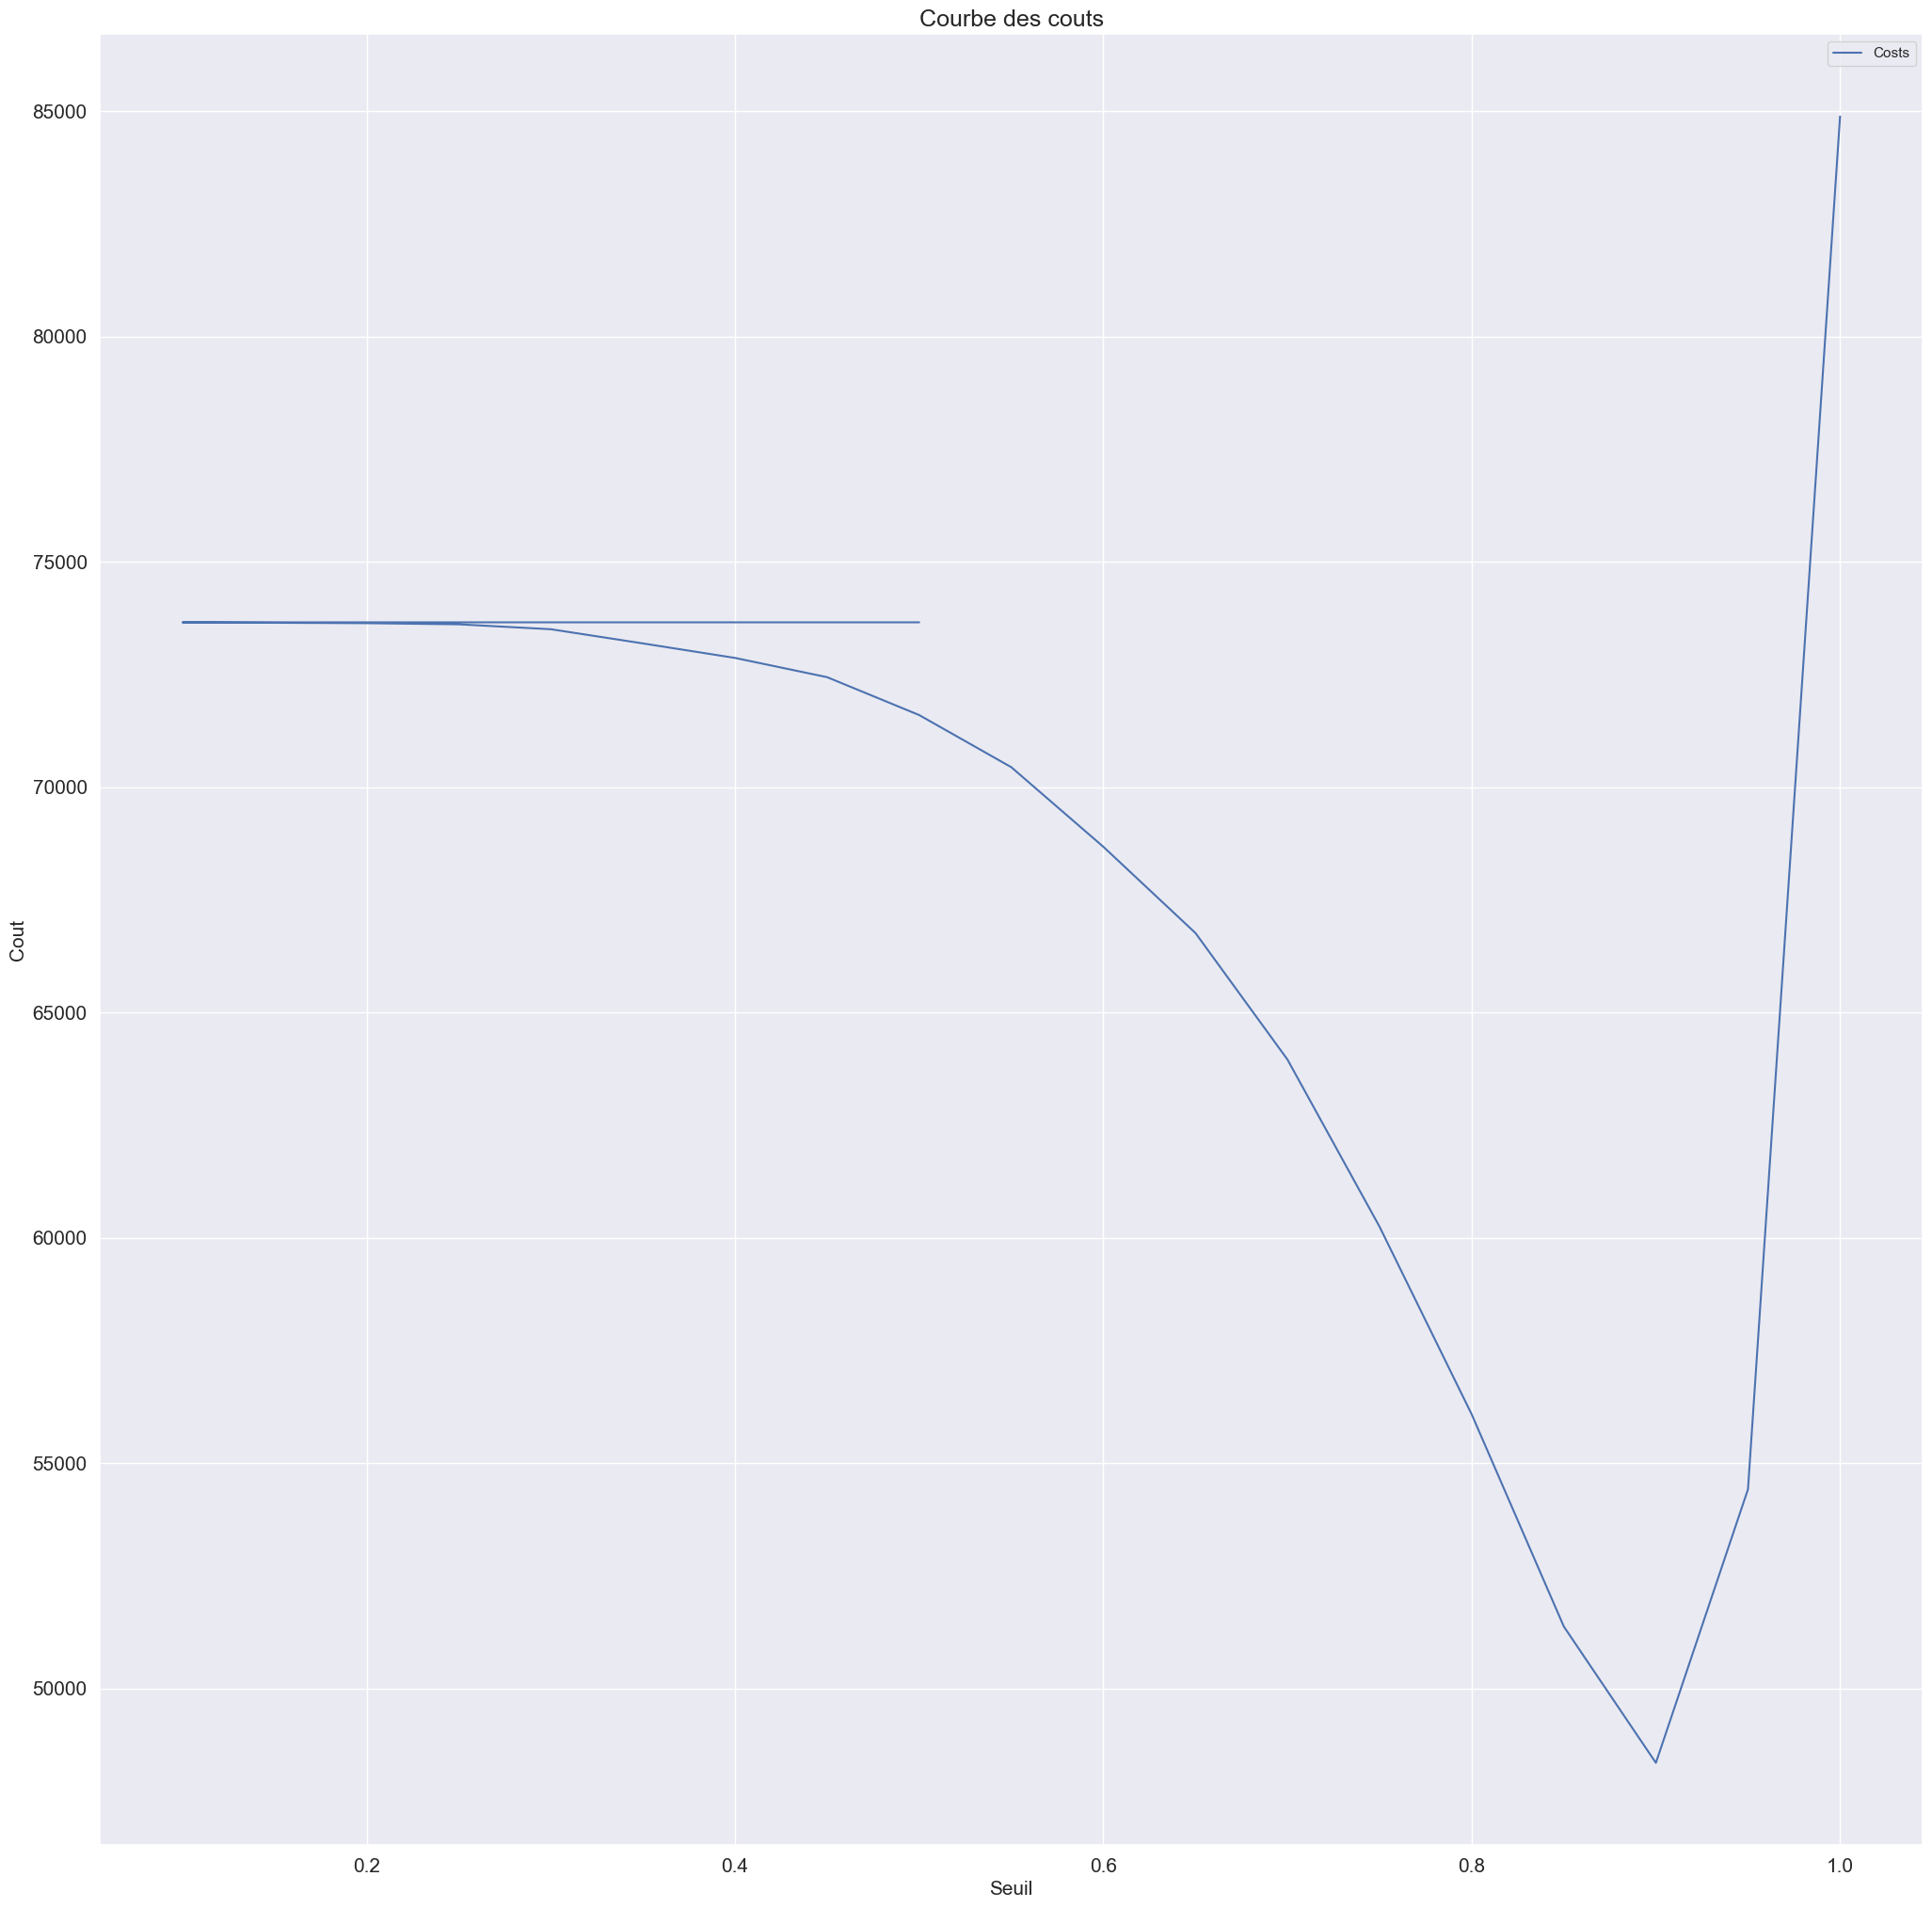

In [239]:
ax = table_curve.plot(x='Threshold',kind='line', y='Costs', title='Courbe des couts')
ax.set_xlabel('Seuil', fontsize=15)
ax.set_ylabel('Cout', fontsize=15)
ax.set_title('Courbe des couts', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show

<AxesSubplot:>

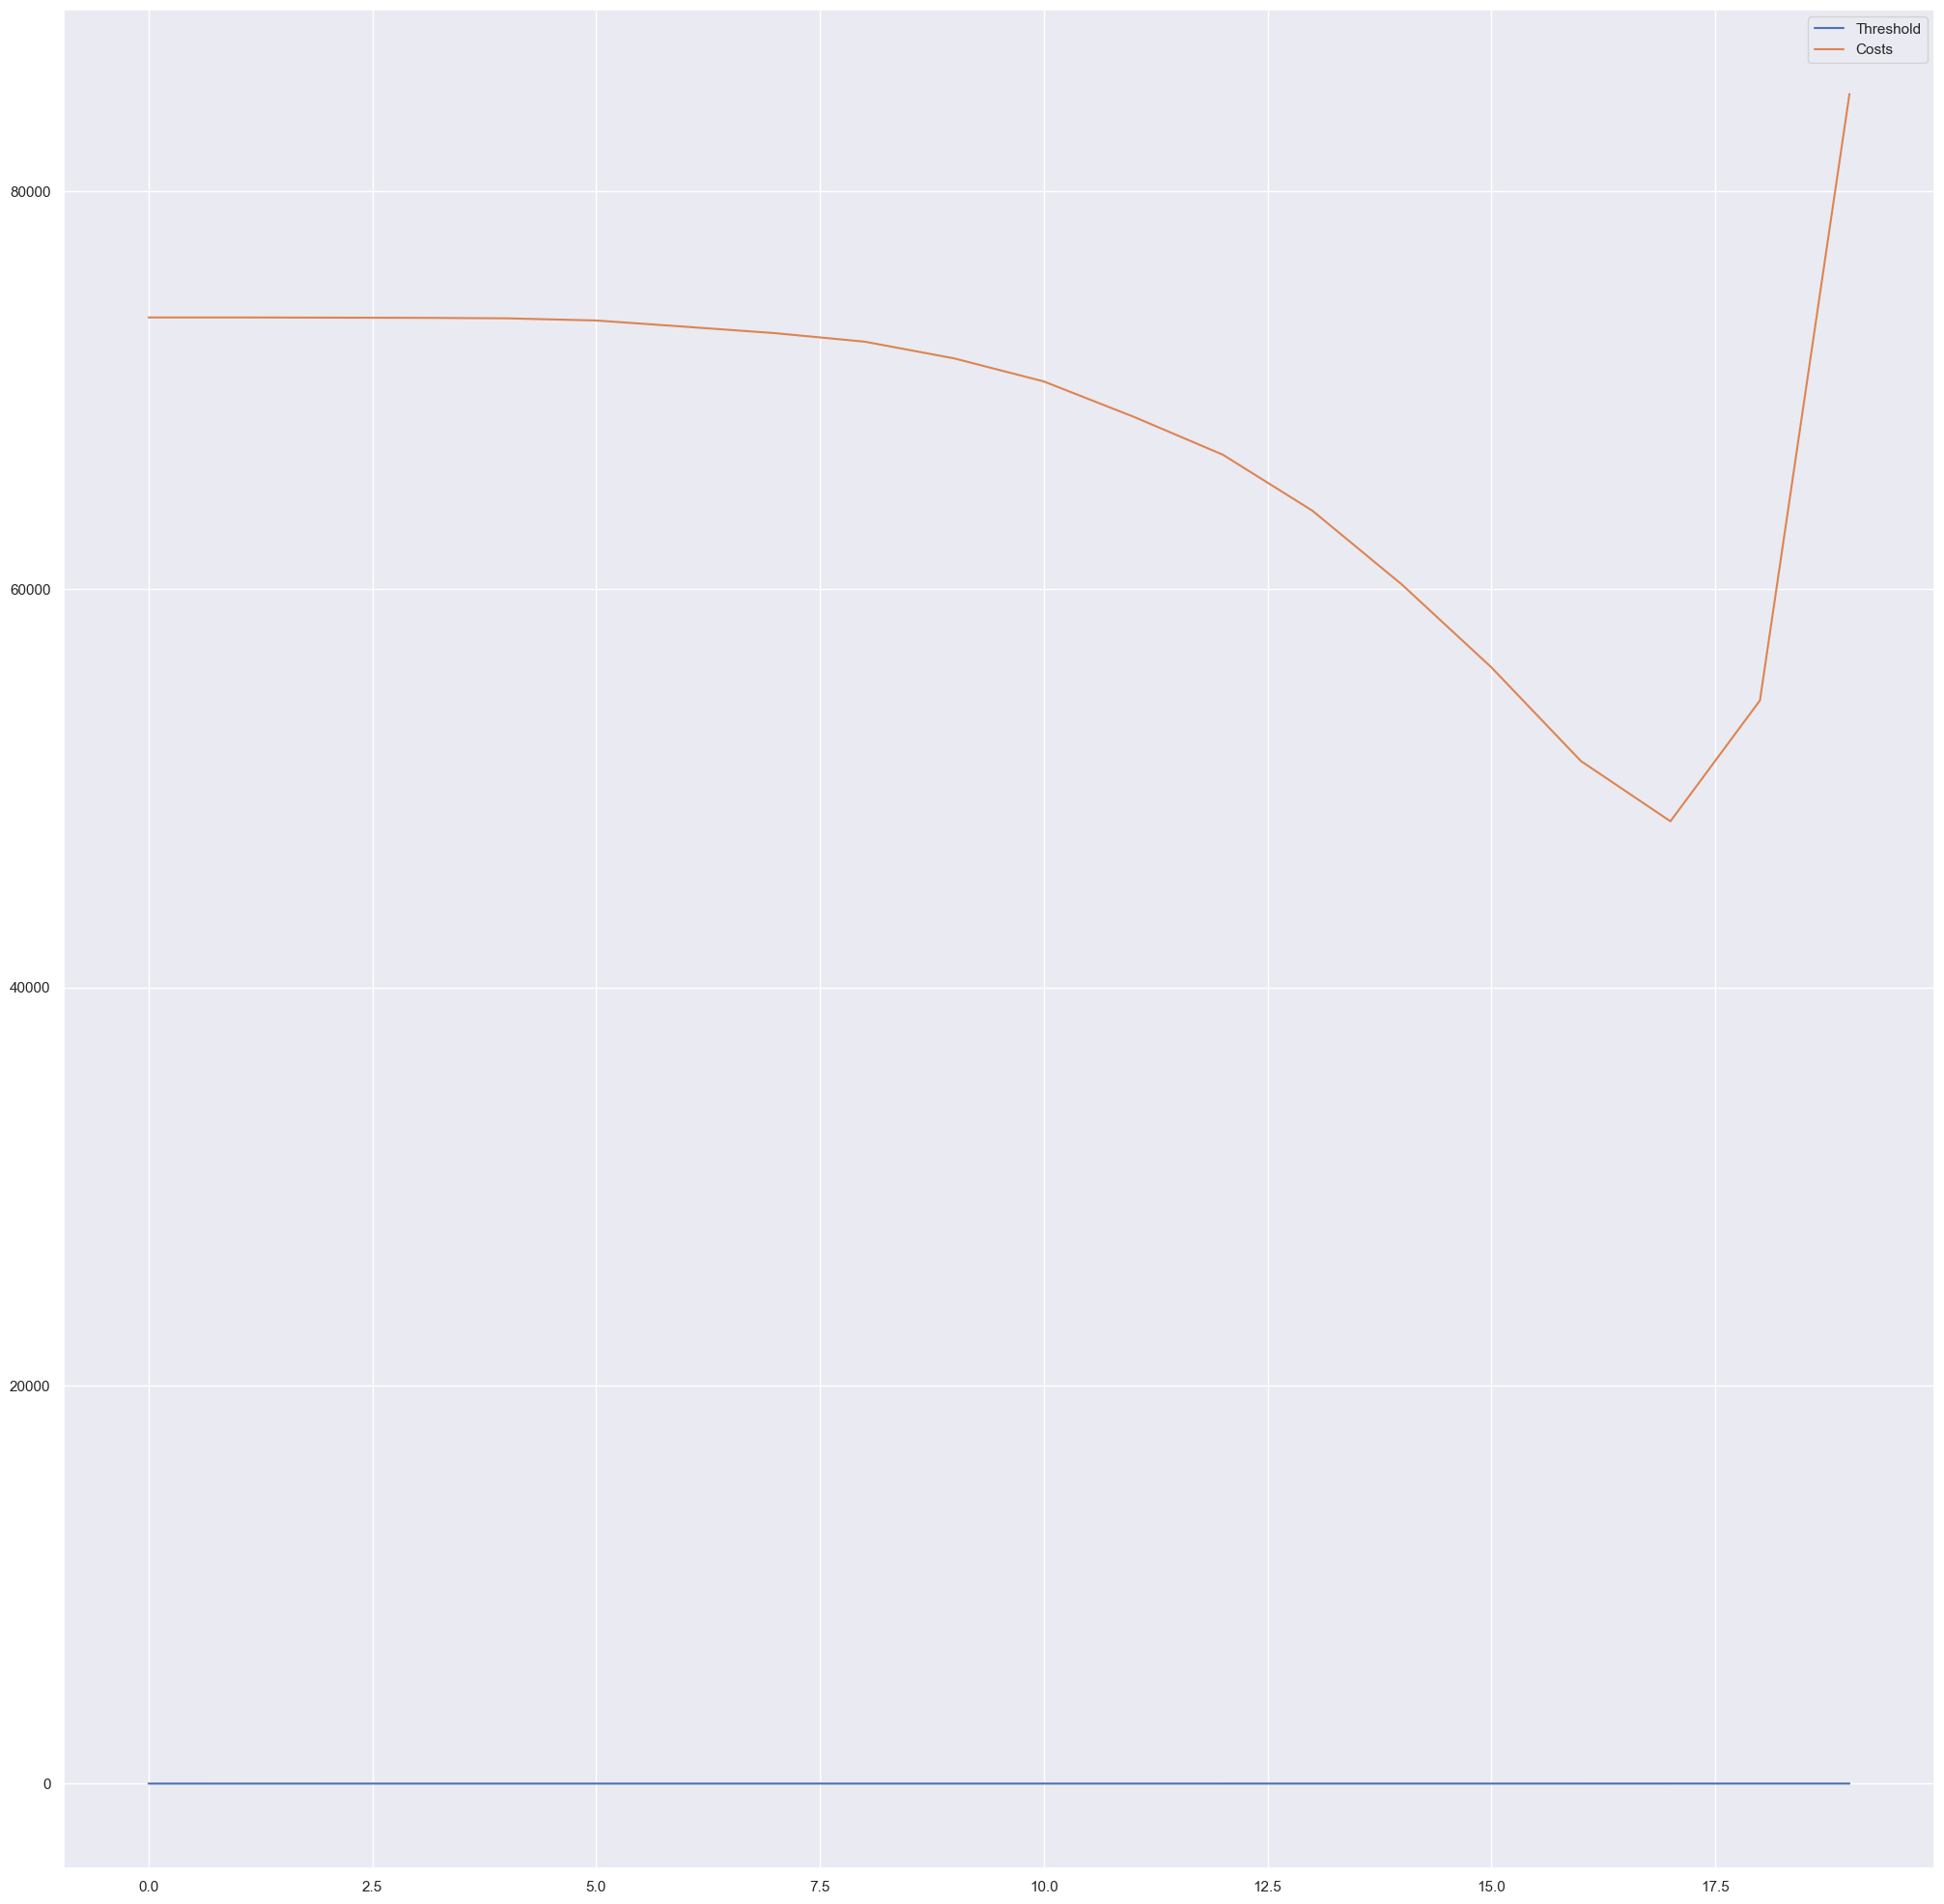

In [238]:
table_curve.plot()

### !!!! TO RUN ONLY AT THE END Adding sk curr id to X_test to use it with SHAP # run it only at the end when using shap

In [59]:
X_test.insert(0, 'SK_ID_CURR', X['SK_ID_CURR'])
X_test

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
201658,333760,1,0,0,0.018029,-6718.0,-326,0,0,3,...,0,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148
299253,446681,1,1,0,0.028663,-208.0,-4447,0,1,2,...,0,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931
23676,127549,1,0,0,0.024610,-1524.0,-3995,0,0,2,...,0,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102
29875,134681,0,1,1,0.025164,-3746.0,-2156,0,0,2,...,0,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000
9612,111178,1,0,1,0.031329,-2848.0,-2854,1,1,2,...,0,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,377384,0,1,0,0.046220,-1543.0,-4779,0,0,1,...,0,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194
157793,282899,1,0,0,0.014520,-6944.0,-1645,0,0,2,...,0,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636
148954,272698,1,0,0,0.031329,-2324.0,-991,0,0,2,...,0,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477
104381,221138,1,1,1,0.014520,-2803.0,-3633,1,1,2,...,0,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240


### (run ONLY when exporting the dataframe with the sk curr ID) adding sk curr id to x_new  

In [61]:

X_test_scld_cols.insert(0, 'SK_ID_CURR', X['SK_ID_CURR'])

X_test_scld_cols

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,207120,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


input_data_scaled_fake = input_data_scaled
input_data_scaled_fake

input_data_scaled = input_data_scaled.drop('SK_ID_CURR', axis=1)

input_data_scaled_fake = input_data_scaled_fake.drop('SK_ID_CURR', axis=1)

input_data_scaled_fake.insert(0,'SK_ID_CURR', input_data_scaled_fake.index)
input_data_scaled_fake   #######testsre se funziona con tutti i plot di shap, e se si, esportarlo su github per usarlo su streamlit share

In [192]:
input_data_scaled_fake

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
100003,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
100004,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
100006,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
100007,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207117,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
207118,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
207119,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183


### Streamlit goal, after selecting from a liste deroulante les festures quantitatives, I want an histogram with 3 columns, feature client, feature moyenne clients acceptees, feature moyenne clients refusees

In [183]:
cols_to_keep =["PREDICTION",
"SK_ID_CURR",
"AMT_INCOME_TOTAL",
"AMT_CREDIT",
"AMT_ANNUITY",
"REGION_POPULATION_RELATIVE",
"DAYS_BIRTH",
"DAYS_EMPLOYED",
"DAYS_REGISTRATION",
"DAYS_ID_PUBLISH",
"FLAG_MOBIL",
"FLAG_WORK_PHONE",
"FLAG_CONT_MOBILE",
"FLAG_PHONE",
"FLAG_EMAIL",
"CNT_FAM_MEMBERS",
"REGION_RATING_CLIENT",
"REG_REGION_NOT_LIVE_REGION",
"REG_REGION_NOT_WORK_REGION",
"REG_CITY_NOT_LIVE_CITY",
"REG_CITY_NOT_WORK_CITY",
"EXT_SOURCE_1",
"EXT_SOURCE_2",
"EXT_SOURCE_3",
"BASEMENTAREA_MODE",
"ELEVATORS_MODE",
"LANDAREA_MODE",
"OBS_60_CNT_SOCIAL_CIRCLE",
"DEF_60_CNT_SOCIAL_CIRCLE",
"FLAG_DOCUMENT_2",
"AMT_REQ_CREDIT_BUREAU_HOUR",
"AMT_REQ_CREDIT_BUREAU_DAY",
"AMT_REQ_CREDIT_BUREAU_WEEK",
"AMT_REQ_CREDIT_BUREAU_MON",
"AMT_REQ_CREDIT_BUREAU_QRT",
"AMT_REQ_CREDIT_BUREAU_YEAR"]

In [184]:
existing_columns = [col for col in cols_to_keep if col in X_test_strl_jnd.columns]
existing_columns

['PREDICTION',
 'SK_ID_CURR',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'BASEMENTAREA_MODE',
 'ELEVATORS_MODE',
 'LANDAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [194]:
X_test_strl_jnd

,PREDICTION,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
201658,1,333760,1,0,0,0.018029,-6718.0,-326,0,0,...,0,0,0,0,0,0,0.597450,75000.0,0.123640,0.092148
299253,1,446681,1,1,0,0.028663,-208.0,-4447,0,1,...,0,0,0,0,0,0,0.041081,92250.0,0.132732,0.036931
23676,0,127549,1,0,0,0.024610,-1524.0,-3995,0,0,...,0,0,0,0,0,1,0.118733,112500.0,0.172880,0.048102
29875,0,134681,0,1,1,0.025164,-3746.0,-2156,0,0,...,0,0,0,0,0,0,0.234085,45000.0,0.066667,0.050000
9612,0,111178,1,0,1,0.031329,-2848.0,-2854,1,1,...,0,0,0,0,0,0,0.204406,20250.0,0.182111,0.057915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,0,377384,0,1,0,0.046220,-1543.0,-4779,0,0,...,0,0,0,0,0,0,0.124076,180000.0,0.131312,0.038194
157793,0,282899,1,0,0,0.014520,-6944.0,-1645,0,0,...,0,0,0,0,0,0,0.027954,90000.0,0.087000,0.031636
148954,0,272698,1,0,0,0.031329,-2324.0,-991,0,0,...,0,0,0,0,0,0,0.043236,184500.0,0.117610,0.079477
104381,0,221138,1,1,1,0.014520,-2803.0,-3633,1,1,...,0,0,0,0,0,0,0.428220,45000.0,0.292400,0.029240


In [246]:
data_strl_notscld = X_test_strl_jnd.loc[index_list, lista_features]
data_strl_notscld

KeyError: '[100950, 103109, 107737, 107776, 108005, 108364, 108778, 110102, 110754, 113081, 115235, 116288, 118139, 118441, 118467, 121876, 121959, 125014, 126128, 128035, 128806, 129396, 132231, 133909, 136892, 138575, 138664, 139046, 139716, 140008, 141142, 142617, 144401, 144407, 145316, 149072, 150925, 151991, 152243, 153992, 156148, 156781, 157221, 161245, 163976, 164763, 165447, 166022, 167999, 169818, 170566, 174155, 174946, 175051, 175348, 178697, 179778, 181021, 184390, 184666, 187055, 187596, 188330, 189052, 191321, 193308, 194041, 194458, 196273, 200944, 201302] not in index'

In [195]:
subset_df_features_strl = X_test_strl_jnd[existing_columns]
subset_df_features_strl

,PREDICTION,SK_ID_CURR,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,EXT_SOURCE_3,BASEMENTAREA_MODE,ELEVATORS_MODE,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
201658,1,333760,0.018029,-6718.0,-326,0,0,3,0,0,...,0.167408,0.0000,0.0,0.0000,1.0,0.0,0,0.0,0.0,1.0
299253,1,446681,0.028663,-208.0,-4447,0,1,2,0,0,...,0.263647,0.0000,0.0,0.0000,0.0,0.0,0,0.0,0.0,3.0
23676,0,127549,0.024610,-1524.0,-3995,0,0,2,0,0,...,0.577969,0.0000,0.0,0.0251,0.0,0.0,0,0.0,2.0,2.0
29875,0,134681,0.025164,-3746.0,-2156,0,0,2,0,0,...,0.000000,0.0498,0.0,0.0096,0.0,0.0,0,0.0,0.0,1.0
9612,0,111178,0.031329,-2848.0,-2854,1,1,2,0,0,...,0.576209,0.0000,0.0,0.0000,4.0,0.0,0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,0,377384,0.046220,-1543.0,-4779,0,0,1,0,1,...,0.665855,0.0890,0.0,0.0162,0.0,0.0,0,2.0,2.0,2.0
157793,0,282899,0.014520,-6944.0,-1645,0,0,2,0,0,...,0.522697,0.0773,0.0,0.0458,7.0,5.0,0,0.0,2.0,0.0
148954,0,272698,0.031329,-2324.0,-991,0,0,2,0,0,...,0.315472,0.0000,0.0,0.0000,3.0,0.0,0,0.0,1.0,4.0
104381,0,221138,0.014520,-2803.0,-3633,1,1,2,0,0,...,0.438281,0.0000,0.0,0.0000,0.0,0.0,0,0.0,1.0,2.0


In [196]:
clients_accepted = subset_df_features_strl[subset_df_features_strl['PREDICTION'] == 0]
clients_accepted

,PREDICTION,SK_ID_CURR,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,EXT_SOURCE_3,BASEMENTAREA_MODE,ELEVATORS_MODE,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
23676,0,127549,0.024610,-1524.0,-3995,0,0,2,0,0,...,0.577969,0.0000,0.0000,0.0251,0.0,0.0,0,0.0,2.0,2.0
29875,0,134681,0.025164,-3746.0,-2156,0,0,2,0,0,...,0.000000,0.0498,0.0000,0.0096,0.0,0.0,0,0.0,0.0,1.0
9612,0,111178,0.031329,-2848.0,-2854,1,1,2,0,0,...,0.576209,0.0000,0.0000,0.0000,4.0,0.0,0,0.0,0.0,3.0
208090,0,341188,0.026392,-2940.0,-2431,0,0,2,0,0,...,0.726711,0.0000,0.0000,0.0000,0.0,0.0,0,3.0,0.0,0.0
198201,0,329803,0.046220,-4219.0,-2696,1,1,1,0,1,...,0.000000,0.1180,0.3222,0.1367,1.0,0.0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239532,0,377384,0.046220,-1543.0,-4779,0,0,1,0,1,...,0.665855,0.0890,0.0000,0.0162,0.0,0.0,0,2.0,2.0,2.0
157793,0,282899,0.014520,-6944.0,-1645,0,0,2,0,0,...,0.522697,0.0773,0.0000,0.0458,7.0,5.0,0,0.0,2.0,0.0
148954,0,272698,0.031329,-2324.0,-991,0,0,2,0,0,...,0.315472,0.0000,0.0000,0.0000,3.0,0.0,0,0.0,1.0,4.0
104381,0,221138,0.014520,-2803.0,-3633,1,1,2,0,0,...,0.438281,0.0000,0.0000,0.0000,0.0,0.0,0,0.0,1.0,2.0


In [197]:
clients_refused = subset_df_features_strl[subset_df_features_strl['PREDICTION'] == 1]
clients_refused

,PREDICTION,SK_ID_CURR,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,...,EXT_SOURCE_3,BASEMENTAREA_MODE,ELEVATORS_MODE,LANDAREA_MODE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_2,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
201658,1,333760,0.018029,-6718.0,-326,0,0,3,0,0,...,0.167408,0.0000,0.0000,0.0000,1.0,0.0,0,0.0,0.0,1.0
299253,1,446681,0.028663,-208.0,-4447,0,1,2,0,0,...,0.263647,0.0000,0.0000,0.0000,0.0,0.0,0,0.0,0.0,3.0
33300,1,138580,0.010500,-3782.0,-3776,0,0,3,0,0,...,0.459690,0.0000,0.0000,0.0000,4.0,0.0,0,0.0,0.0,4.0
555,1,100641,0.028663,-11393.0,-2704,0,0,2,0,0,...,0.000000,0.0000,0.0000,0.0000,0.0,0.0,0,0.0,0.0,1.0
22721,1,126435,0.008068,-5538.0,-1991,1,1,3,0,0,...,0.546023,0.0000,0.0000,0.0000,0.0,0.0,0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10583,1,112328,0.008230,-1304.0,-3690,1,0,2,0,0,...,0.300108,0.0000,0.0000,0.0000,1.0,0.0,0,0.0,0.0,0.0
88889,1,203207,0.020713,-2575.0,-3420,0,0,3,0,0,...,0.000000,0.1108,0.0806,0.0378,0.0,0.0,0,0.0,0.0,1.0
68649,1,179617,0.026392,-4666.0,-153,0,0,2,0,0,...,0.258084,0.0000,0.0000,0.0000,0.0,0.0,0,0.0,0.0,3.0
237486,1,375083,0.020246,-4281.0,-959,1,0,3,0,0,...,0.544235,0.0871,0.0000,0.0304,1.0,0.0,0,0.0,0.0,2.0


In [198]:
mean_good_clients = clients_accepted.iloc[:, 2:].mean()
mean_bad_clients = clients_refused.iloc[:, 2:].mean()
list_index_names= ['REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'REGION_RATING_CLIENT',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'BASEMENTAREA_MODE',
 'ELEVATORS_MODE',
 'LANDAREA_MODE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

## STREAMLIT Dataframe features streamlit

In [200]:
df_strl_means = pd.DataFrame({
    'Good Clients': mean_good_clients,
    'Bad Clients': mean_bad_clients
},index=list_index_names)

df_strl_means    # to export in joblinb

,Good Clients,Bad Clients
REGION_POPULATION_RELATIVE,0.021786,0.018276
DAYS_REGISTRATION,-5266.378039,-4297.829595
DAYS_ID_PUBLISH,-3132.042923,-2646.761023
FLAG_WORK_PHONE,0.182671,0.242652
FLAG_PHONE,0.303910,0.218866
REGION_RATING_CLIENT,1.999834,2.187693
REG_REGION_NOT_LIVE_REGION,0.012892,0.016901
REG_REGION_NOT_WORK_REGION,0.047968,0.054649
REG_CITY_NOT_LIVE_CITY,0.057938,0.124575
REG_CITY_NOT_WORK_CITY,0.194298,0.322788


In [248]:
X_test_scld_cols

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,207120,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


In [211]:
X_test_scld_cols["Target"] = y_test.values

### Shap

In [1]:
# to use with shap, df with the ID
X_test

NameError: name 'X_test' is not defined

In [90]:
X_test_sld_shap = X_test_scld_cols.drop('SK_ID_CURR', axis=1)   #perké l ho fatto???
X_test_sld_shap

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


In [163]:
input_data_scaled  #devo usare questo dataframe, in questo modo posso usare lo stesso indice che uso per fare la predizione

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183


In [124]:
import shap
import shap.maskers
shap.initjs()  # JavaScript plots

In [213]:
# Calculating SHAP values for the model, and summary plot (1a cella da eseguire per il summary plot)

explainer = shap.TreeExplainer(light_for_shap)

In [232]:
joblib.dump (explainer, 'local_explainer.joblib')     # exporting working local explainer to see if it works in remote and goal is to resolve the difference between expacted values

['local_explainer.joblib']

#### Force plot

In [208]:
#testing shap 7 maggio  force plot, modifica del 9 ottobre


def generate_force_plot(client_id, data, model_explainer):
    """
    Genera un force plot per un ID cliente specifico.
    
    Parametri:
    - client_id: ID del cliente di interesse
    - data: DataFrame contenente i dati dei clienti (deve avere una colonna 'SK_ID_CURR')
    - model_explainer: Oggetto SHAP TreeExplainer già addestrato
    
    Restituisce:
    - Un force plot per l'ID cliente specificato
    """
    
    # Seleziona i dati del cliente specificato dall'ID
    client_data = data.loc[[client_id]].drop('SK_ID_CURR', axis=1)
    
    # Calcola i valori SHAP per il cliente specifico
    client_shap_values = model_explainer.shap_values(client_data)
    
    # Ottiene il valore atteso dal model_explainer
    base_value = model_explainer.expected_value

    # Genera e restituisce il force plot
    return shap.force_plot(base_value[0], client_shap_values[0], client_data)

In [235]:
client_id = random.choice(id_list)
generate_force_plot(126128, lighter_input_streamlit, explainer)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


#### Summary plot

shap.summary_plot(shap_values, input_data_scaled_fake.drop('SK_ID_CURR', axis=1))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


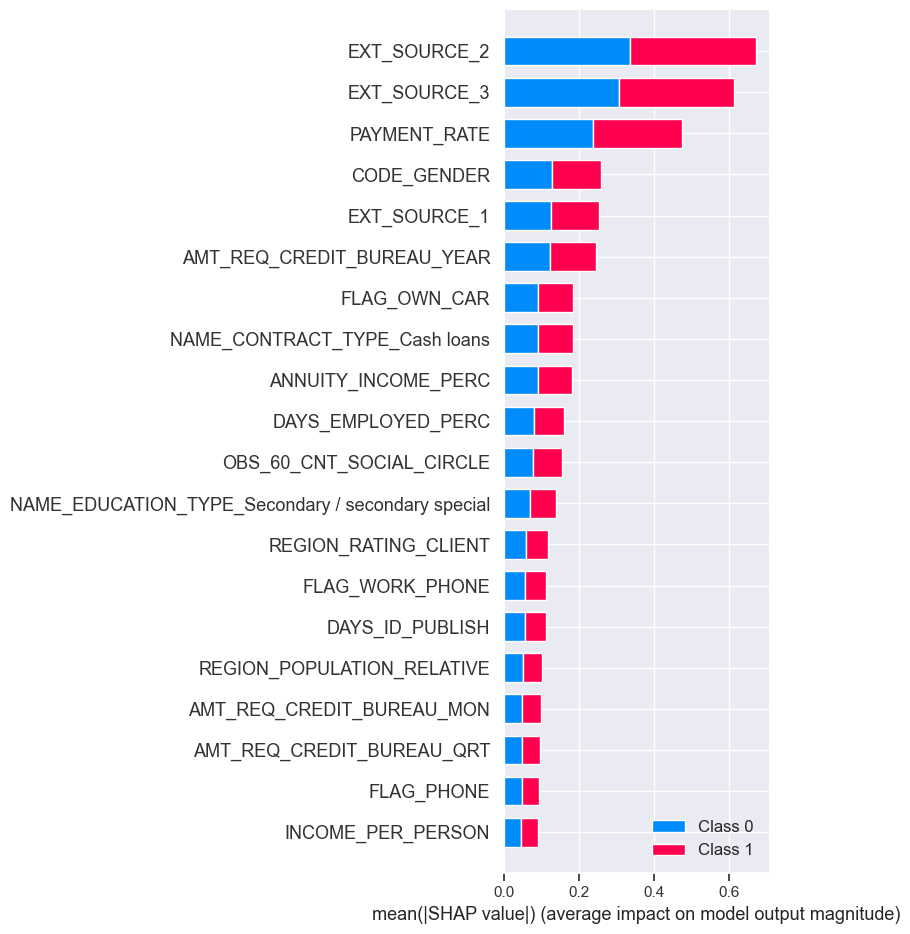

In [214]:
# Calcola i valori SHAP per tutto il dataset di test
# shap_values_all = explainer.shap_values(X_test_scld_cols.drop('SK_ID_CURR', axis=1))
# 
# Crea un summary plot
shap_values = explainer.shap_values(lighter_input_streamlit.drop('SK_ID_CURR', axis=1))
shap.summary_plot(shap_values, lighter_input_streamlit.drop('SK_ID_CURR', axis=1))

In [149]:
X_test_scld_cols

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,207120,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


In [158]:
X_test_scaled.shape

(92254, 90)

#### Waterfall plot

In [227]:
import shap

def generate_waterfall_plot(client_id, data, explainer):
    """
    Genera un waterfall plot per un ID cliente specifico.
    
    Parametri:
    - client_id: ID del cliente di interesse
    - data: DataFrame contenente i dati dei clienti (deve avere una colonna 'SK_ID_CURR')
    - explainer: Oggetto SHAP Explainer già addestrato
    
    Restituisce:
    - Un waterfall plot per l'ID cliente specificato
    """
    # Seleziona i dati per il cliente specifico
    example_instance = data.loc[[client_id]].drop('SK_ID_CURR', axis=1)
    
    # Calcola i valori SHAP per l'istanza specifica
    shap_values = explainer.shap_values(example_instance)
    print(len(shap_values[0][0]))
    # Calcola il valore base del modello
    expected_value = explainer.expected_value[0]  # Stiamo lavorando con la classe negativa
    print(expected_value)
    
    # Visualizza l'ID del Cliente
    print("SHAP Waterfall Plot per il Cliente ID:", client_id)
    
    # Crea e mostra il Waterfall Plot
    shap.plots.waterfall(shap.Explanation(values=shap_values[0][0], 
                                          base_values=expected_value, 
                                          data=example_instance.values[0], 
                                          feature_names=example_instance.columns.tolist()))

In [230]:
lighter_input_streamlit.loc[[127444]].drop('SK_ID_CURR', axis=1).values[0]


array([ 0.71977446, -0.71987857, -0.66503931, -0.12971795, -0.58833898,
        1.38256034, -0.49893709, -0.6259168 , -0.10303767, -0.12599975,
       -0.23221964, -0.29255511, -0.54733057, -0.76730399,  0.11583812,
       -1.52472636, -0.52408061, -0.35554311, -0.43051144, -0.17561484,
       -0.27761682, -0.00681603, -0.26803032, -0.28477676, -0.44128193,
        0.32524103, -0.32524103, -0.55118563, -0.00431078,  2.1360308 ,
       -0.27490929, -0.00963954, -1.03403179, -0.02198584, -0.56693375,
       -0.11259953,  0.63872998, -0.32874868,  0.75380362, -0.41746682,
       -0.23454362,  0.35695811, -0.09275082, -0.12728729, -0.2255659 ,
       -0.1811323 , -0.12523658, -0.1411524 , -0.31378809, -0.25405332,
       -0.19573927, -0.08220872, -0.27398936, -0.16820968, -0.09353736,
       -0.3420521 , -0.1487697 , -0.06675573, -0.44373741,  2.16427898,
       -0.08919464, -0.09133925, -0.53266239, -0.15000475, -0.18788972,
       -0.05756713, -0.03430339, -0.10417541, -0.05383255, -0.10

In [219]:
lighter_input_streamlit

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
100950,100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937
201302,201302,0.719774,-0.719879,-0.665039,1.829814,-2.453286,-0.914616,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,0.047969,-0.230534,1.914070,1.956059


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


90
1.9004447598206093
SHAP Waterfall Plot per il Cliente ID: 126128


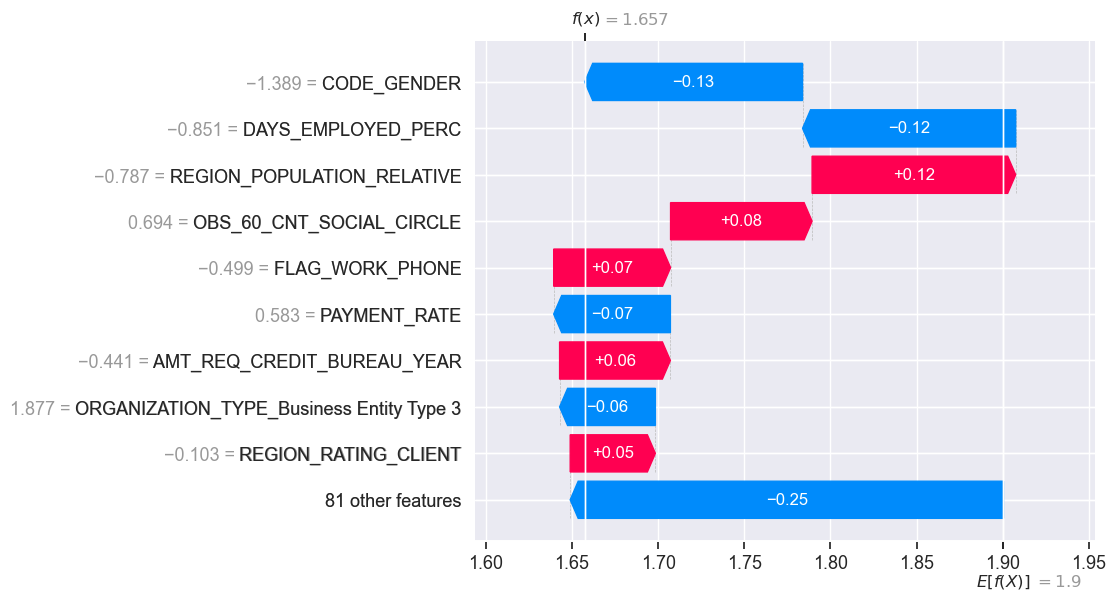

In [237]:
# Esempio di utilizzo:
generate_waterfall_plot(126128, lighter_input_streamlit, explainer)

import shap

######### Supponiamo che 'explainer' sia il tuo oggetto SHAP Explainer già creato
######### e 'example_instance' sia la tua istanza specifica per cui vuoi generare il plot

shap_values = explainer.shap_values(input_data_scaled)

#shap values already computed, in previous cellules
######## Calcola il valore base del modello
expected_value = explainer.expected_value[0]   # per ottenere la classe negativa, quindi i bravi clienti

######## Ottieni i nomi delle feature
feature_names = input_data_scaled.columns.tolist()

######## Crea il Waterfall Plot per la classe negativa
shap.plots.waterfall(shap.Explanation(values=shap_values[0][0], 
                                      base_values=expected_value, 
                                      data=input_data_scaled.values[0], 
                                      feature_names=feature_names))

In [104]:
# shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], X_test_scaled[0], features_colss)  # ça produisait un resultat mais je ne le savais pas expliquer

In [110]:
X_test_scld_cols

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
1,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
2,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
3,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
4,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92249,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
92250,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
92251,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183
92252,207120,0.719774,1.389123,1.503671,-0.460726,0.618625,-0.424021,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,2.286232,-0.431708,1.178683,-1.088753


In [ ]:
print(len(shap_values[0]))
print(len(shap_values[1]))
print(len(id_list))

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[1][0], X_test_scaled[1], features_colss)

#### Summary plot

In [ ]:
shap.summary_plot(shap_values, features_colss)   # (2a cella da eseguire per il summary plot)

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:500,:], X_train_smote_df.iloc[:500,:])

In [ ]:
X_test_scaled.shape

In [ ]:
X_test_scld_cols.shape

### Stocking objects into JOBLIB files

In [104]:
import joblib

In [195]:
input_data_scaled_fake

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,100002,0.719774,-0.719879,-0.665039,-0.207177,-0.492679,1.768406,-0.498937,-0.625917,1.861322,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,3.676623,-0.163475,-0.606128,1.709899
100003,100003,0.719774,1.389123,-0.665039,0.561201,1.355237,-0.963675,-0.498937,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.894501,-0.009241,-0.509974,-0.746572
100004,100004,0.719774,-0.719879,-0.665039,0.268345,0.981680,-0.664015,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,2.135593,-0.256516,0.171816,-0.085364,-0.249597
100006,100006,-1.389152,1.389123,1.503671,0.308375,0.350947,0.555179,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.691218,-0.431708,-1.208680,-0.165176
100007,100007,0.719774,-0.719879,1.503671,0.753838,0.605852,0.092429,2.004261,1.597656,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,0.447371,-0.653001,0.012264,0.186957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207117,207117,-1.389152,1.389123,-0.665039,1.829814,0.976286,-1.183780,-0.498937,-0.625917,-2.067397,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.212616,0.775341,-0.524983,-0.690391
207118,207118,0.719774,-0.719879,-0.665039,-0.460726,-0.556831,0.893955,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-1.002355,-0.029359,-0.993634,-0.982143
207119,207119,0.719774,-0.719879,-0.665039,0.753838,0.754593,1.327534,-0.498937,-0.625917,-0.103038,...,-0.045617,-0.162321,-0.062366,-0.13281,-0.066014,-0.468254,-0.876795,0.815576,-0.669904,1.146183


In [105]:
joblib.dump (lighter_input_df_sorted, 'data4pyan.joblib')

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_WORK_PHONE,FLAG_PHONE,REGION_RATING_CLIENT,REG_REGION_NOT_LIVE_REGION,...,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
100950,0.719774,-0.719879,-0.665039,-0.717527,1.360346,-0.329217,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.685222,-0.290886,0.481527,0.106266
103109,0.719774,-0.719879,-0.665039,-0.812111,-1.743925,-0.593077,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.525821,0.797859
105548,0.719774,1.389123,-0.665039,-0.309565,0.976286,-1.067098,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.272404,-1.171119,0.023660
107108,-1.389152,-0.719879,-0.665039,-0.460726,1.410021,-0.951742,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,2.135593,-0.256516,0.372991,-0.776473,0.344108
107737,-1.389152,1.389123,-0.665039,-0.013240,-0.076827,1.226763,-0.498937,-0.625917,1.861322,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-0.731416,-0.029359,-1.501019,2.722762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194458,0.719774,-0.719879,-0.665039,-1.234380,0.189432,-1.761223,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,1.662899,0.171816,-1.137045,0.042933
196273,0.719774,1.389123,-0.665039,-0.151395,0.583711,0.776610,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,-1.101029,-0.178309,-0.940375,-0.165176
200944,-1.389152,1.389123,1.503671,-0.995426,0.517572,-1.047872,-0.498937,-0.625917,-0.103038,-0.126,...,-0.045617,-0.162321,-0.062366,7.529554,-0.066014,-0.468254,-0.993010,-0.431708,0.522969,-1.088937
201302,0.719774,-0.719879,-0.665039,1.829814,-2.453286,-0.914616,-0.498937,-0.625917,-2.067397,-0.126,...,-0.045617,-0.162321,-0.062366,-0.132810,-0.066014,-0.468254,0.047969,-0.230534,1.914070,1.956059


In [141]:
joblib.dump (lighter_input_streamlit, 'data4streamlit_light.joblib')

['data4streamlit_light.joblib']

In [216]:
joblib.dump (df_tenrows, 'sample_ten_rows.joblib')

['sample_ten_rows.joblib']

In [217]:
joblib.dump (df_strl_means, 'feature_means.joblib')

['feature_means.joblib']

In [ ]:
joblib.dump (id_list, 'list_id_clients.joblib')

In [165]:
joblib.dump (explainer,'shap_explainer.joblib')

['shap_explainer.joblib']

In [ ]:
joblib.dump (features_colss,'features.joblib')

In [ ]:
joblib.dump(X_test_scaled, 'test_data.joblib') # yeah it's ok to import directly standardized data, in order to avoid scaling them for each entry in the dashboard 

In [ ]:
joblib.dump(scaler, 'standardscaler.joblib')

In [169]:
joblib.dump(light_for_shap, 'lightgbmodelsh.joblib')

['lightgbmodelsh.joblib']

In [ ]:
joblib.dump(X_test, "input_data.joblib")

### Exporting dataframe (x test scaled) that will be used for streamlit share

In [111]:
import joblib

joblib.dump(X_test_scld_cols, 'X_tst_sld_skid_ok.joblib')

['X_tst_sld_skid_ok.joblib']

In [ ]:
def get_client(x_test):
    features_list=[]
    values_list=[]
    for k,v in x_test.sample().to_dict().items():
        features_list.append(k)
        for key,val in v.items():
            values_list.append(val)

    return dict(zip(features_list, values_list))


In [ ]:
get_client(X_test)

In [ ]:
list_entry = X_test.sample().values
list_entry

In [ ]:
ls

premierment mlflow.... NO
api est un endpoint
dashboard

Pandas profiling??

In [ ]:
import pandas_profiling

In [ ]:
# pandas_profiling.ProfileReport(train_df)